# Install and load packages

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
pip install scanpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install fastcluster

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install git+https://github.com/simslab/scHPF.git#egg=scHPF

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/simslab/scHPF.git to /tmp/pip-install-kglwdvjn/schpf_8a03eccc8f324b4dab63918d8051fa2a
  Running command git clone -q https://github.com/simslab/scHPF.git /tmp/pip-install-kglwdvjn/schpf_8a03eccc8f324b4dab63918d8051fa2a
  Resolved https://github.com/simslab/scHPF.git to commit aff30d674039359395cbee4ca4ddc85f3a5c8b56
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import os, errno
import datetime
import uuid
import itertools
import yaml
import subprocess
import scipy.sparse as sp
from scipy.spatial.distance import squareform
from sklearn.decomposition import non_negative_factorization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import sparsefuncs
from fastcluster import linkage
from scipy.cluster.hierarchy import leaves_list
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scanpy as sc
import schpf
%matplotlib inline
from scipy.io import mmread
from IPython.display import Image
import anndata
import pickle

In [ ]:
if not os.path.exists("sccHPF"):
    ! git clone https://github.com/nicholashou27/sccHPF.git

In [ ]:
! python sccHPF/setup.py install

running install
/burg/opt/anaconda3-2022.05/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/burg/opt/anaconda3-2022.05/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
error: can't create or remove files in install directory

The following error occurred while trying to add or remove files in the
installation directory:

    [Errno 13] Permission denied: '/burg/opt/anaconda3-2022.05/lib/python3.9/site-packages/test-easy-install-2465859.write-test'

The installation directory you specified (via --install-dir, --prefix, or
the distutils default setting) was:

    /burg/opt/anaconda3-2022.05/lib/python3.9/site-packages/

Perhaps your account does not have write access to this directory?  If the


In [ ]:
import sccHPF

# Upload data

In [ ]:
# load data
adata = sc.read_mtx(
    '/content/drive/My Drive/PhD/Research/RG Factor Analysis/CombinedDrug/drug_raw.mtx'
)

# gene names
GeneList = pd.read_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/CombinedDrug/drug_features.tsv",
                       sep=' ',
                       header = None)
adata.var['gene_ids'] = GeneList.values[:,0]
adata.var_names = GeneList.values[:,1]

# cell line annotations
CellLine = pd.read_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/CombinedDrug/cell_line.tsv",
                       sep=' ',
                       header = None)
adata.obs['cell_line'] = CellLine.values

# sc.pp.filter_cells(adata, min_genes=200) # filter cells with fewer than 200 genes
# sc.pp.filter_cells(adata, min_counts=200)  # This is a weaker threshold than above. It is just to population the n_counts column in adata
# sc.pp.filter_genes(adata, min_cells=3) # filter genes detected in fewer than 3 cells

adata.var_names_make_unique()

# select cell line: T98G, U87MG, A172 or BT333
# adata = adata[adata.obs['cell_line'] == "BT333"]

# select training subset
train_adata = adata[adata.obs['cell_line'] == "BT333"]
adata


KeyboardInterrupt



# Preliminary Drug Screen: sccHPF Analysis

In [ ]:
count_adat_fn = '/content/drive/My Drive/PhD/Research/RG Factor Analysis/counts.h5ad'
sc.write(count_adat_fn, adata)

In [ ]:
numiter=3 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=2000 ## Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = '/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF'
run_name = 'projected_model_sccHPF_test'

## Specify the Ks to use as a space separated list in this case "5 6 7 8 9 10"
first_K, last_K = 2, 2
K = ' '.join([str(i) for i in range(first_K,last_K+1)])

seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = '/content/drive/My Drive/PhD/Research/RG Factor Analysis/counts.h5ad'

In [ ]:
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = sccHPF.cNMF(output_dir=output_directory, name=run_name)
cnmf_obj._initialize_dirs()

In [ ]:
## Prepare the data, I.e. subset to 2000 high-variance genes, and variance normalize
# cnmf_obj.prepare(counts_fn=countfn, components=np.arange(5,11), n_iter=20, seed=14, num_highvar_genes=2000)

k_components = list(np.arange(first_K,last_K+1))

train = True

print('preparing normalized data...')
input_counts = adata.to_df()
tpm = sccHPF.compute_tpm(input_counts)
sccHPF.save_df_to_npz(tpm, cnmf_obj.paths['tpm'])
input_tpm_stats = pd.DataFrame([tpm.mean(axis=0), tpm.std(axis=0)],index = ['__mean', '__std']).T
sccHPF.save_df_to_npz(input_tpm_stats, cnmf_obj.paths['tpm_stats'])

if train:
    print("preparing training data...")
    train_input_counts = train_adata.to_df()
    train_tpm = sccHPF.compute_tpm(train_input_counts)
    sccHPF.save_df_to_npz(train_tpm, cnmf_obj.paths['train_tpm'])
    train_input_tpm_stats = pd.DataFrame([train_tpm.mean(axis=0), train_tpm.std(axis=0)],index = ['__mean', '__std']).T
    sccHPF.save_df_to_npz(train_input_tpm_stats, cnmf_obj.paths['train_tpm_stats'])

    norm_counts, train_norm_counts = cnmf_obj.get_norm_counts(input_counts, num_highvar_genes=numhvgenes,
                                                              train_set=True, train_counts_df=train_input_counts)
    cnmf_obj.save_norm_counts(norm_counts)
    cnmf_obj.save_train_norm_counts(train_norm_counts)
else:
    norm_counts = cnmf_obj.get_norm_counts(input_counts, num_highvar_genes=numhvgenes)
    cnmf_obj.save_norm_counts(norm_counts)

run_params = cnmf_obj.get_nmf_iter_params(ks=k_components, n_iter=numiter, random_state_seed=seed)
cnmf_obj.save_nmf_iter_params(run_params)

preparing normalized data...
preparing training data...


In [ ]:
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
# cnmf_obj.factorize(worker_i=0, total_workers=1)

cnmf_obj.run_nmf(worker_i=0, total_workers=1,
                 train_set=True,
                 train_X=train_norm_counts)

In [ ]:
# cnmf_obj.combine()

run_params = sccHPF.load_df_from_npz(cnmf_obj.paths['nmf_parameters'])

if type(k_components) is int:
    ks = [k_components]
elif k_components is None:
    ks = sorted(set(run_params.n_components))
else:
    ks = k_components

for k in ks:
    cnmf_obj.combine_nmf(k)

Combining factorizations for k=2.


[Iter.    0]  loss:39.612995  pct:100.000000000
[Iter.   10]  loss:13.547562  pct:-65.800206931
[Iter.   20]  loss:13.476078  pct:-0.527655156
[Iter.   30]  loss:13.439505  pct:-0.271390169
[Iter.   40]  loss:13.428853  pct:-0.079259301
[Iter.   50]  loss:13.423173  pct:-0.042294849
[Iter.   60]  loss:13.419334  pct:-0.028605585
[Iter.   70]  loss:13.416358  pct:-0.022171833
[Iter.   80]  loss:13.414087  pct:-0.016930660
[Iter.   90]  loss:13.412326  pct:-0.013126501
[Iter.  100]  loss:13.410898  pct:-0.010648606
[Iter.  110]  loss:13.409687  pct:-0.009028146
[Iter.  120]  loss:13.408640  pct:-0.007807846
converged
New best!
Trial 0 loss: 13.408640
Best loss: 13.408640 (trial 0)
[Iter.    0]  loss:72941.757316  pct:100.000000000
[Iter.   10]  loss:7736.440136  pct:-89.393674597
[Iter.   20]  loss:7735.536126  pct:-0.011685085
[Iter.   30]  loss:7728.632031  pct:-0.089251672
[Iter.   40]  loss:7678.419917  pct:-0.649689537
[Iter.   50]  loss:7653.985091  pct:-0.318227268
[Iter.   60]  l

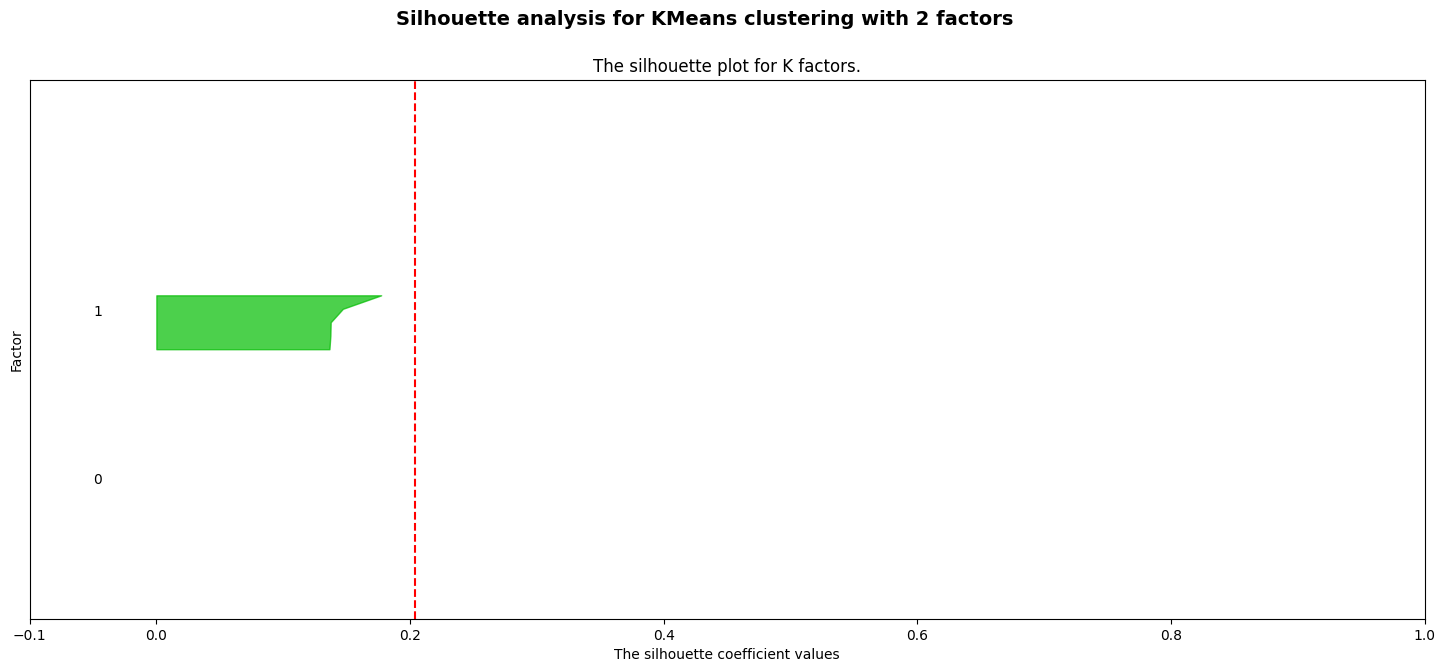

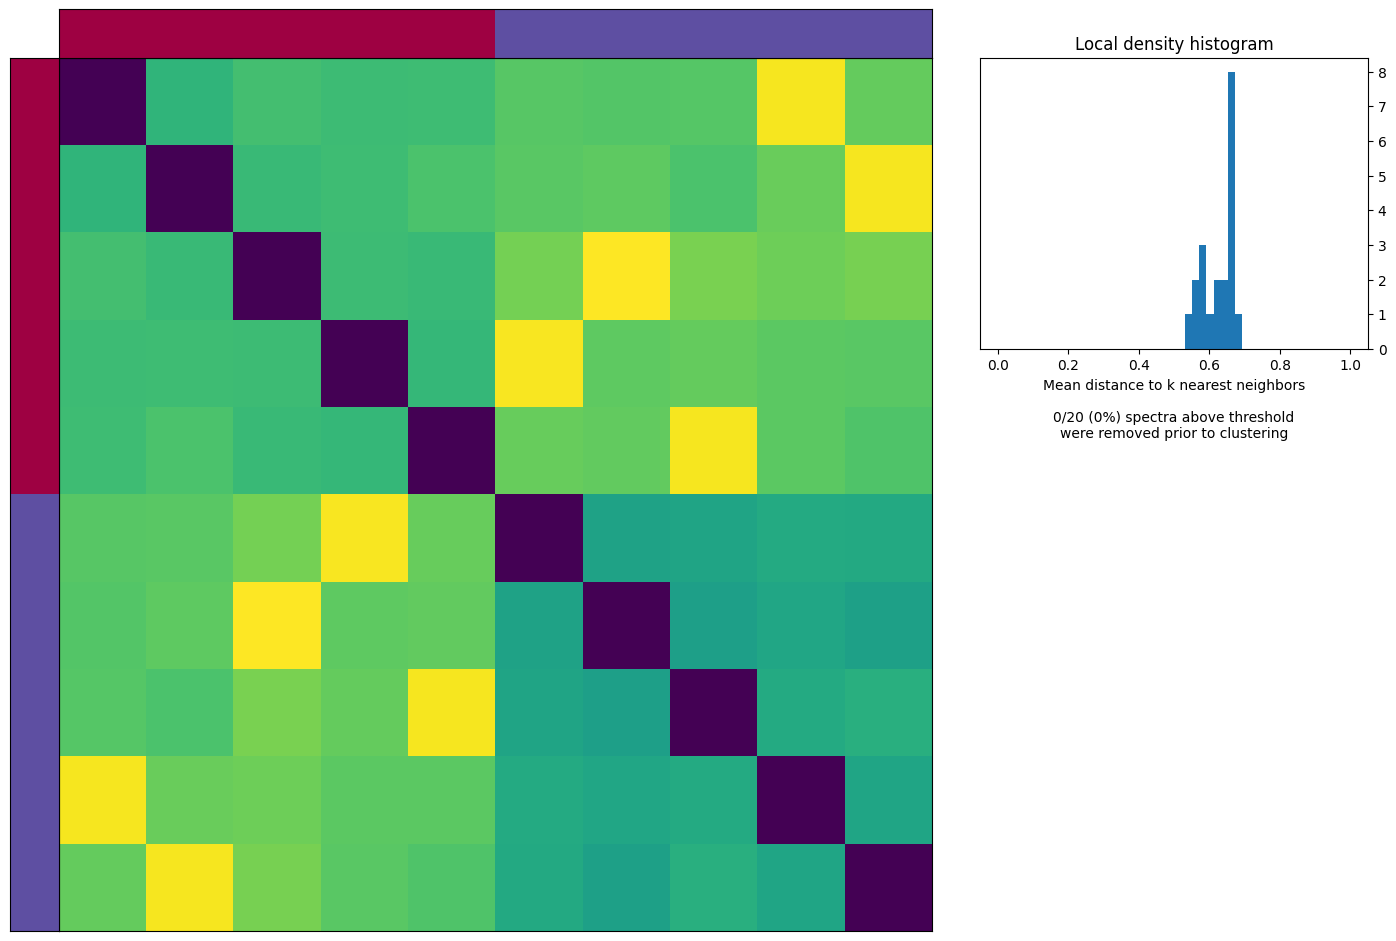

In [ ]:
# cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

n_top_genes = 20
density_threshold = 2

run_params = sccHPF.load_df_from_npz(cnmf_obj.paths['nmf_parameters'])

# retrieve the consensus for each k value and save the files
for k in ks:
    merged_spectra = sccHPF.load_df_from_npz(cnmf_obj.paths['merged_spectra']%k)
    cnmf_obj.consensus(k, str(density_threshold), show_clustering = True, close_clustergram_fig=False)

    # usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=i, density_threshold=density_threshold)
    scorefn = cnmf_obj.paths['gene_spectra_score__txt'] % (k, str(density_threshold).replace('.', '_'))
    tpmfn = cnmf_obj.paths['gene_spectra_tpm__txt'] % (k, str(density_threshold).replace('.', '_'))
    usagefn = cnmf_obj.paths['consensus_usages__txt'] % (k, str(density_threshold).replace('.', '_'))
    spectra_scores = pd.read_csv(scorefn, sep='\t', index_col=0).T
    spectra_tpm = pd.read_csv(tpmfn, sep='\t', index_col=0).T

    usage = pd.read_csv(usagefn, sep='\t', index_col=0)
    usage = usage.div(usage.sum(axis=1), axis=0)

    try:
        usage.columns = [int(x) for x in usage.columns]
    except:
        print('Usage matrix columns include non integer values')

    top_genes = []
    for gep in spectra_scores.columns:
        top_genes.append(list(spectra_scores.sort_values(by=gep, ascending=False).index[:n_top_genes]))

    top_genes = pd.DataFrame(top_genes, index=spectra_scores.columns).T
    usage_norm, gep_scores, gep_tpm, topgenes = usage, spectra_scores, spectra_tpm, top_genes

    if not os.path.exists("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/" % k):
      os.mkdir("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/" % k)
    usage_norm.to_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/usage_norm.csv" % k)

    if not os.path.exists("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/" % k):
      os.mkdir("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/" % k)
    gep_scores.to_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/gep_scores.csv" % k)

    if not os.path.exists("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/" % k):
      os.mkdir("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/" % k)
    gep_tpm.to_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/gep_tpm.csv" % k)

    if not os.path.exists("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/" % k):
      os.mkdir("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/" % k)
    topgenes.to_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/drug_BT333_sccHPF_test/%d/topgenes.csv" % k)

# Preliminary Drug Screen: K selection and Visualization

In [ ]:
# k_selection_plot

cnmf_obj.k_selection_plot(close_fig=False)

In [ ]:
# Load results for a single selected k: cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)

selected_K = 8
density_threshold = 2

n_top_genes = 20
scorefn = cnmf_obj.paths['gene_spectra_score__txt'] % (selected_K, str(density_threshold).replace('.', '_'))
tpmfn = cnmf_obj.paths['gene_spectra_tpm__txt'] % (selected_K, str(density_threshold).replace('.', '_'))
usagefn = cnmf_obj.paths['consensus_usages__txt'] % (selected_K, str(density_threshold).replace('.', '_'))
spectra_scores = pd.read_csv(scorefn, sep='\t', index_col=0).T
spectra_tpm = pd.read_csv(tpmfn, sep='\t', index_col=0).T

usage = pd.read_csv(usagefn, sep='\t', index_col=0)
usage = usage.div(usage.sum(axis=1), axis=0)

try:
    usage.columns = [int(x) for x in usage.columns]
except:
    print('Usage matrix columns include non integer values')

top_genes = []
for gep in spectra_scores.columns:
    top_genes.append(list(spectra_scores.sort_values(by=gep, ascending=False).index[:n_top_genes]))

top_genes = pd.DataFrame(top_genes, index=spectra_scores.columns).T

usage_norm, gep_scores, gep_tpm, topgenes = usage, spectra_scores, spectra_tpm, top_genes
usage_norm.columns = ['Usage_%d' % i for i in usage_norm.columns]

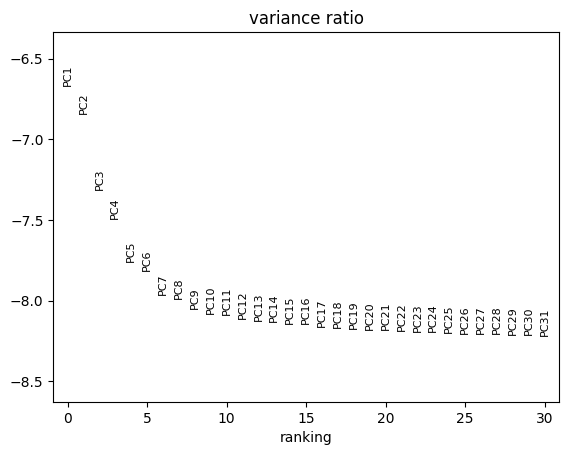

In [ ]:
adata = sc.read(countfn)

## Obtain high variance genes that were used for cNMF as these were saved to a text file
# hvgs = open('/content/drive/My Drive/PhD/Research/RG Factor Analysis/cNMF/drug_sccHPF/drug_sccHPF.overdispersed_genes.txt').read().split('\n')

sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4) ## TPT normalization

## Set log-normalized data to the raw attribute of the AnnData object to make it easy to plot expression levels of individual genes.
## This does not log normalize the actual AnnData data matrix
adata.raw = sc.pp.log1p(adata.copy(), copy=True)

## Subset out only the high-variance genes
# adata = adata[:,hvgs]

## Mean and variance normalize the genes
sc.pp.scale(adata)

## Run PCA
sc.pp.pca(adata)

## Make a scree plot to determine number of PCs to use for UMAP
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
## Construct the nearest neighbor graph for UMAP
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15)

## Run UMAP
sc.tl.umap(adata)

In [ ]:
for i in range(1,selected_K+1):
  adata.obs['Usage_%d' % i] = usage_norm['Usage_%d' % i].values

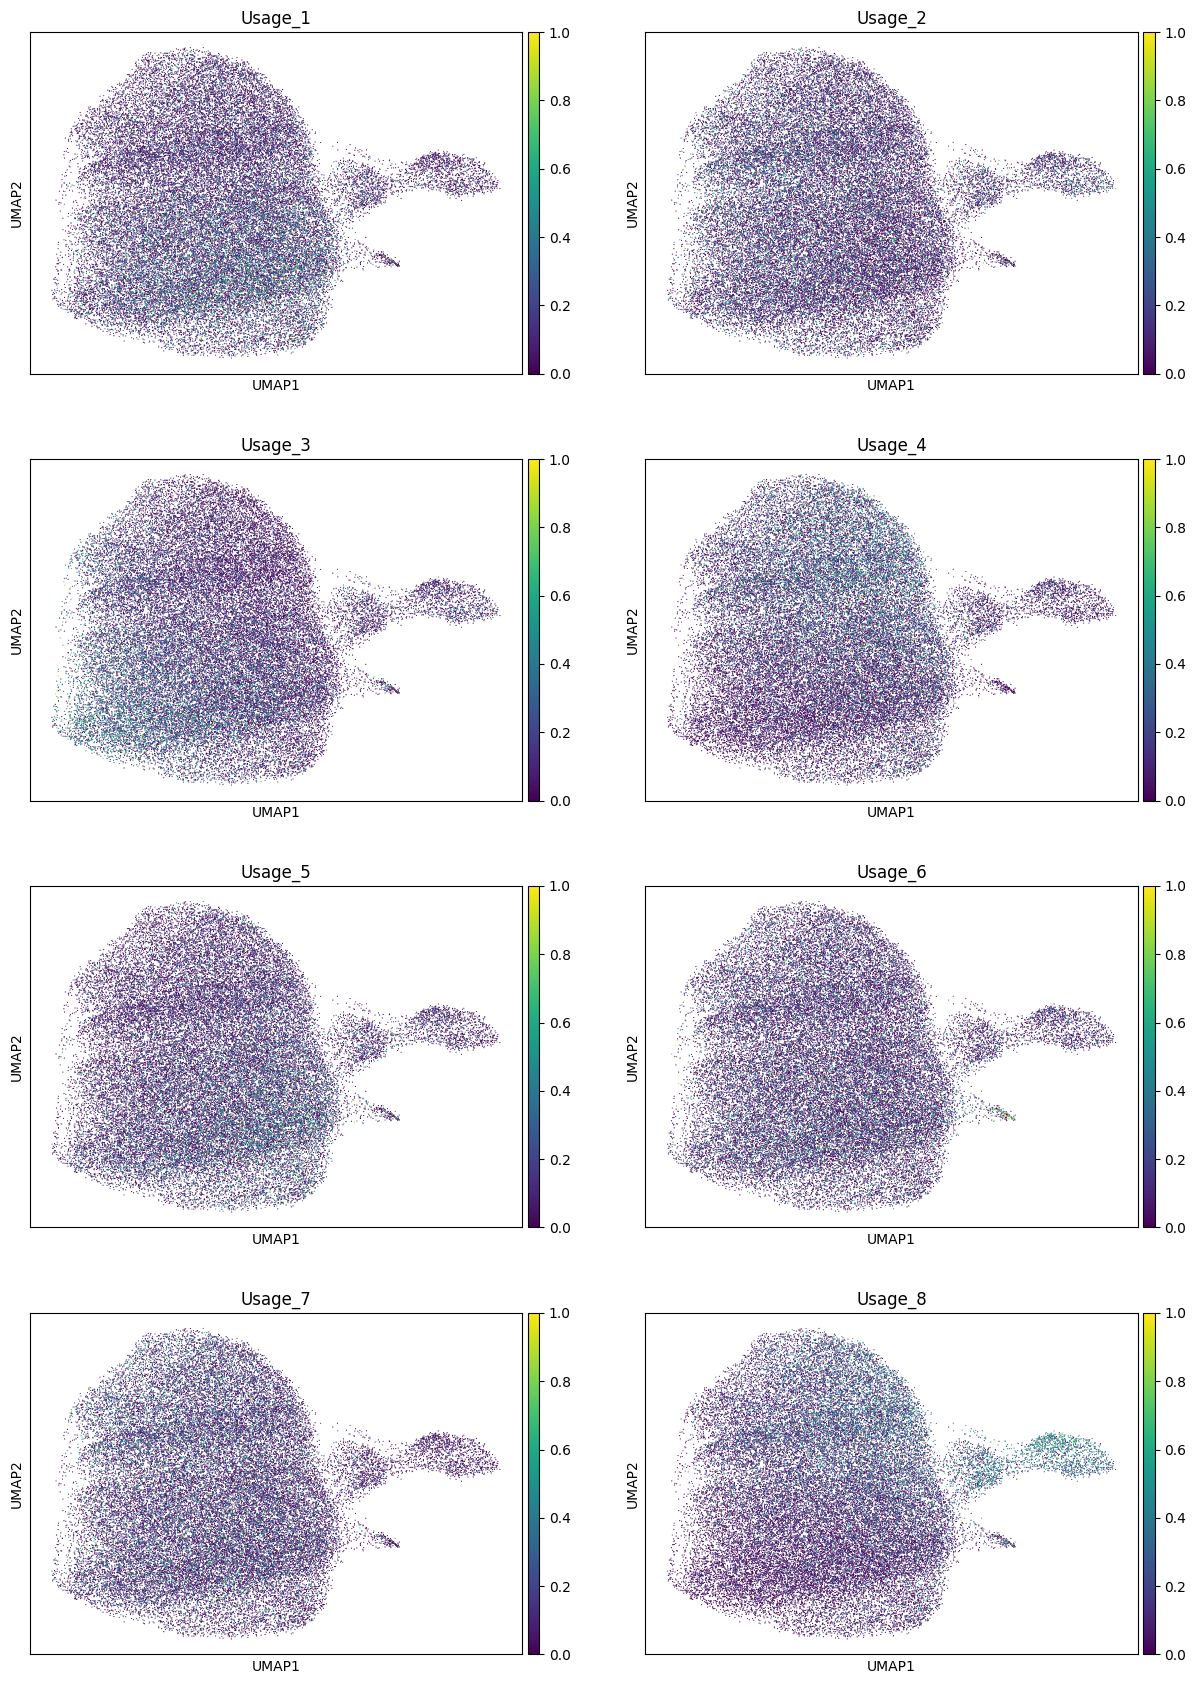

In [ ]:
sc.pl.umap(adata, color=usage_norm.columns,
           use_raw=True, ncols=2, vmin=0, vmax=1)

In [ ]:
topgenes.head(20)

1           2         3           4               5           6  \
0    DYRK1B      WDSUB1     NEAT1       FANCG            XBP1  AC007563.2   
1     STAT6       DDIT3    MALAT1        NGEF         FAM131B       DDX58   
2      DPM3     SLC35D1      DGKI      TYSND1          GEMIN8       THEM4   
3     SOCS3       ITGA8     PRAG1       MED22           HOXB8      PLXNB1   
4     RAB13      MRPL16    RHBDD3      PKMYT1           FBXW9  AC090987.1   
5     ERG28       KYAT3     AXIN1         LIF           MIER2       CAPS2   
6     APBA3        ALX4   ANKRD23    C16orf74            ING4      ZDHHC1   
7      C1RL        MAP6     PHKA2       UQCC2          SLC6A9    ADAMTS10   
8     RBM4B   LOXL1-AS1     GPR68        DVL1        C11orf95     DENND6B   
9   TMEM129       ACOX3     NPTXR     GNPNAT1           AP3S2        NXF1   
10     GMIP    AMMECR1L   SLC2A12      CALHM2  C15orf38-AP3S2        SYN3   
11     SGSH  AL662795.2    RNASEL      INPP5E          PODNL1      MAP3K5   
12     PER1        BOD1      NRG2      ANKRD9      AC016747.1        BAG5   
13    ALG12       EFNB2  TMEM150A       EVA1A           CPEB1       KMT2D   
14   CHST15     SPATA2L      ATF7       YPEL3             ELL     PLEKHA4   
15     UBL3       RAB6B     PTCD1       XRCC3          LMBR1L       LEMD1   
16    LSM10        RRP9    SEMA6C        TUBB         RARRES2      COL6A3   
17    ITPKB      INPP5B       DBP        SIX5          ZNF579    CATSPER2   
18     PARL       CWC25    CHI3L1  AL669831.3              PC      TMEM53   
19    DDX31        BCL6    DZANK1       DUSP7          PMS2P3       AIFM2   

           7           8  
0       RFT1        CTGF  
1    STARD10       ACTG1  
2     ZSWIM7        ACTB  
3       IRF2       TENM1  
4       IRS2        SDC4  
5     GTPBP2        NPC1  
6      HOXB7      INSIG1  
7   GTF2IRD2      PRADC1  
8     MAN2C1      SLC2A3  
9       ANO8        IPO4  
10       TNC      TUBB4B  
11     FNDC4    HSP90AA1  
12      GBP2      TUBA1B  
13     DCLK1      DNAAF3  
14     TRIQK       AP1M2  
15    TTLL11      EIF1AD  
16     DUSP8  AL157935.2  
17    ZNF768       TFPI2  
18    ZNF689     SLC12A8  
19     POC1A       TONSL

# Basal dataset: Upload data

In [ ]:
basal_adata = sc.read_mtx(
    'BTBasal/raw_matrix.mtx'
)

basal_genelist = pd.read_csv("BTBasal/BTBasal_features.tsv",
                       sep=' ',
                       header = None)

CellLine = pd.read_csv("BTBasal/cell_line.tsv",
                       sep=' ',
                       header = None)
basal_adata.obs['cell_line'] = CellLine.values

basal_adata.var['gene_ids'] = basal_genelist.values[:,0]
basal_adata.var_names = basal_genelist.values[:,1]
basal_adata.var_names_make_unique()

basal_adata.var['gene_ids']
basal_adata

AnnData object with n_obs × n_vars = 9846 × 10810
    obs: 'cell_line'
    var: 'gene_ids'

In [ ]:
# select cell line: BT112, BT228 or BT333
basal_adata = basal_adata[basal_adata.obs['cell_line'] == "BT333"]
basal_adata

View of AnnData object with n_obs × n_vars = 5034 × 10810
    obs: 'cell_line'
    var: 'gene_ids'

# Basal dataset: sccHPF Analysis

In [ ]:
count_adat_fn = '/content/drive/My Drive/PhD/Research/RG Factor Analysis/counts.h5ad'
sc.write(count_adat_fn, basal_adata)

numiter=20 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=2000 ## Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = '/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF'
run_name = 'basal_BT228_sccHPF'

## Specify the Ks to use as a space separated list in this case "5 6 7 8 9 10"
first_K, last_K = 2, 12
K = ' '.join([str(i) for i in range(first_K,last_K+1)])

seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = '/content/drive/My Drive/PhD/Research/RG Factor Analysis/counts.h5ad'

## Initialize the cnmf object that will be used to run analyses
cnmf_obj = sccHPF.cNMF(output_dir=output_directory, name=run_name)
cnmf_obj._initialize_dirs()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [ ]:
## Prepare the data, I.e. subset to 2000 high-variance genes, and variance normalize
# cnmf_obj.prepare(counts_fn=countfn, components=np.arange(5,11), n_iter=20, seed=14, num_highvar_genes=2000)

k_components = list(np.arange(first_K,last_K+1))

input_counts = basal_adata.to_df()
tpm = sccHPF.compute_tpm(input_counts)
sccHPF.save_df_to_npz(tpm, cnmf_obj.paths['tpm'])
input_tpm_stats = pd.DataFrame([tpm.mean(axis=0), tpm.std(axis=0)],index = ['__mean', '__std']).T
sccHPF.save_df_to_npz(input_tpm_stats, cnmf_obj.paths['tpm_stats'])

norm_counts = cnmf_obj.get_norm_counts(input_counts, num_highvar_genes=numhvgenes)
cnmf_obj.save_norm_counts(norm_counts)
run_params = cnmf_obj.get_nmf_iter_params(ks=k_components, n_iter=numiter, random_state_seed=seed)
cnmf_obj.save_nmf_iter_params(run_params)

## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
# cnmf_obj.factorize(worker_i=0, total_workers=1)

cnmf_obj.run_nmf(worker_i=0, total_workers=1)

[Worker 0]. Starting task 0.
[Iter.    0]  loss:12.595945  pct:100.000000000
[Iter.   10]  loss:3.022022  pct:-76.007978538
[Iter.   20]  loss:3.016426  pct:-0.185157185
[Iter.   30]  loss:2.986906  pct:-0.978638966
[Iter.   40]  loss:2.979348  pct:-0.253054308
[Iter.   50]  loss:2.977198  pct:-0.072173967
[Iter.   60]  loss:2.975947  pct:-0.041999409
[Iter.   70]  loss:2.975020  pct:-0.031137202
[Iter.   80]  loss:2.974340  pct:-0.022861480
[Iter.   90]  loss:2.973866  pct:-0.015947585
[Iter.  100]  loss:2.973580  pct:-0.009632741
[Iter.  110]  loss:2.973371  pct:-0.007007591
converged
New best!
Trial 0 loss: 2.973371
Best loss: 2.973371 (trial 0)
[Worker 0]. Starting task 1.
[Iter.    0]  loss:12.587131  pct:100.000000000
[Iter.   10]  loss:3.022164  pct:-75.990047396
[Iter.   20]  loss:3.018775  pct:-0.112132121
[Iter.   30]  loss:3.006652  pct:-0.401608153
[Iter.   40]  loss:2.985266  pct:-0.711298358
[Iter.   50]  loss:2.976932  pct:-0.279140381
[Iter.   60]  loss:2.974845  pct:-0

In [ ]:
# cnmf_obj.combine()

run_params = sccHPF.load_df_from_npz(cnmf_obj.paths['nmf_parameters'])

if type(k_components) is int:
    ks = [k_components]
elif k_components is None:
    ks = sorted(set(run_params.n_components))
else:
    ks = k_components

for k in ks:
    cnmf_obj.combine_nmf(k)

Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.


[Iter.    0]  loss:12.629049  pct:100.000000000
[Iter.   10]  loss:3.022211  pct:-76.069368957
[Iter.   20]  loss:3.017381  pct:-0.159803278
[Iter.   30]  loss:2.985197  pct:-1.066649959
[Iter.   40]  loss:2.975040  pct:-0.340235844
[Iter.   50]  loss:2.973814  pct:-0.041217643
[Iter.   60]  loss:2.973219  pct:-0.019998134
[Iter.   70]  loss:2.972752  pct:-0.015696717
[Iter.   80]  loss:2.972506  pct:-0.008296521
[Iter.   90]  loss:2.972419  pct:-0.002930064
converged
New best!
Trial 0 loss: 2.972419
Best loss: 2.972419 (trial 0)
[Iter.    0]  loss:7576.900993  pct:100.000000000
[Iter.   10]  loss:344.397797  pct:-95.454635115
[Iter.   20]  loss:344.355869  pct:-0.012174339
[Iter.   30]  loss:343.223590  pct:-0.328810688
[Iter.   40]  loss:338.511656  pct:-1.372846772
[Iter.   50]  loss:338.500298  pct:-0.003355190
[Iter.   60]  loss:338.520429  pct:0.005946891
converged
New best!
Trial 0 loss: 338.520429
Best loss: 338.520429 (trial 0)


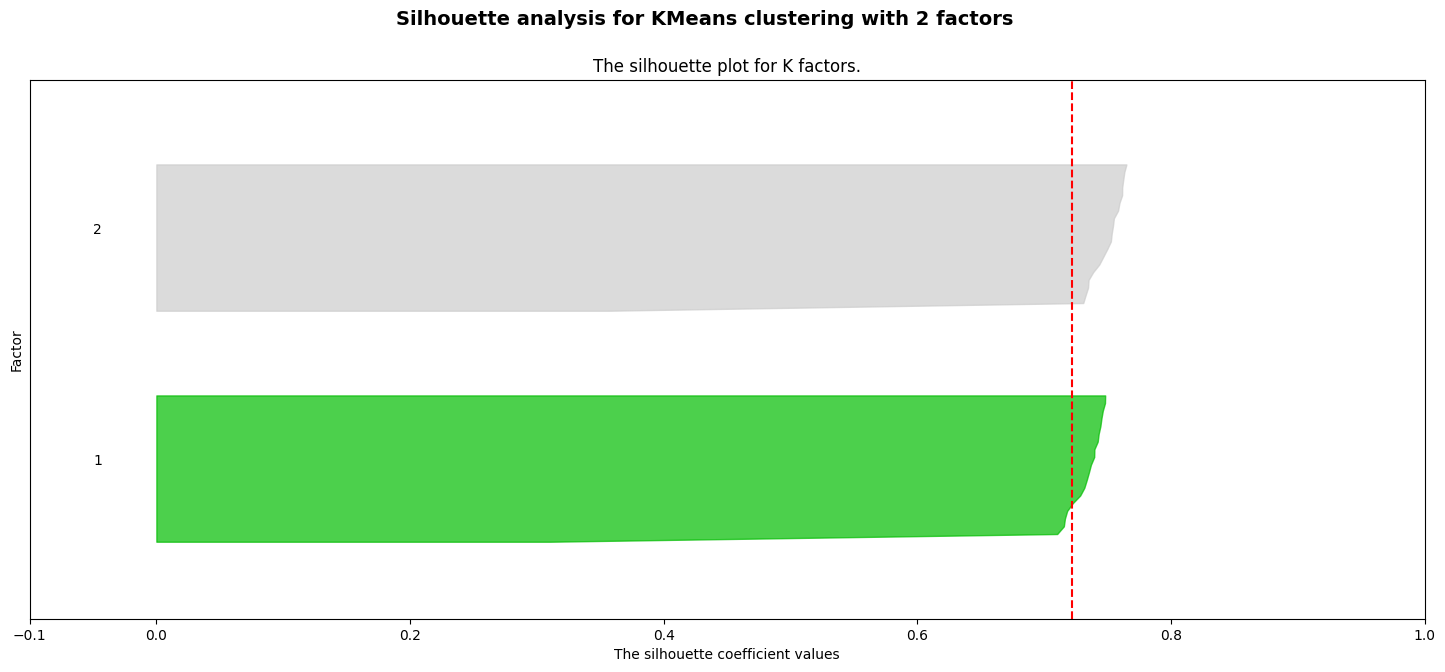

[Iter.    0]  loss:13.660452  pct:100.000000000
[Iter.   10]  loss:3.021252  pct:-77.883217796
[Iter.   20]  loss:3.002252  pct:-0.628882848
[Iter.   30]  loss:2.953060  pct:-1.638501038
[Iter.   40]  loss:2.940682  pct:-0.419169411
[Iter.   50]  loss:2.938707  pct:-0.067174925
[Iter.   60]  loss:2.937794  pct:-0.031041614
[Iter.   70]  loss:2.937400  pct:-0.013419185
[Iter.   80]  loss:2.937151  pct:-0.008470016
[Iter.   90]  loss:2.936995  pct:-0.005331788
converged
New best!
Trial 0 loss: 2.936995
Best loss: 2.936995 (trial 0)
[Iter.    0]  loss:7852.067396  pct:100.000000000
[Iter.   10]  loss:344.395625  pct:-95.613949705
[Iter.   20]  loss:344.348774  pct:-0.013603915
[Iter.   30]  loss:343.453143  pct:-0.260094053
[Iter.   40]  loss:336.916265  pct:-1.903280968
[Iter.   50]  loss:334.055001  pct:-0.849250604
[Iter.   60]  loss:333.913994  pct:-0.042210897
[Iter.   70]  loss:333.840495  pct:-0.022011460
[Iter.   80]  loss:333.796745  pct:-0.013104844
[Iter.   90]  loss:333.764672

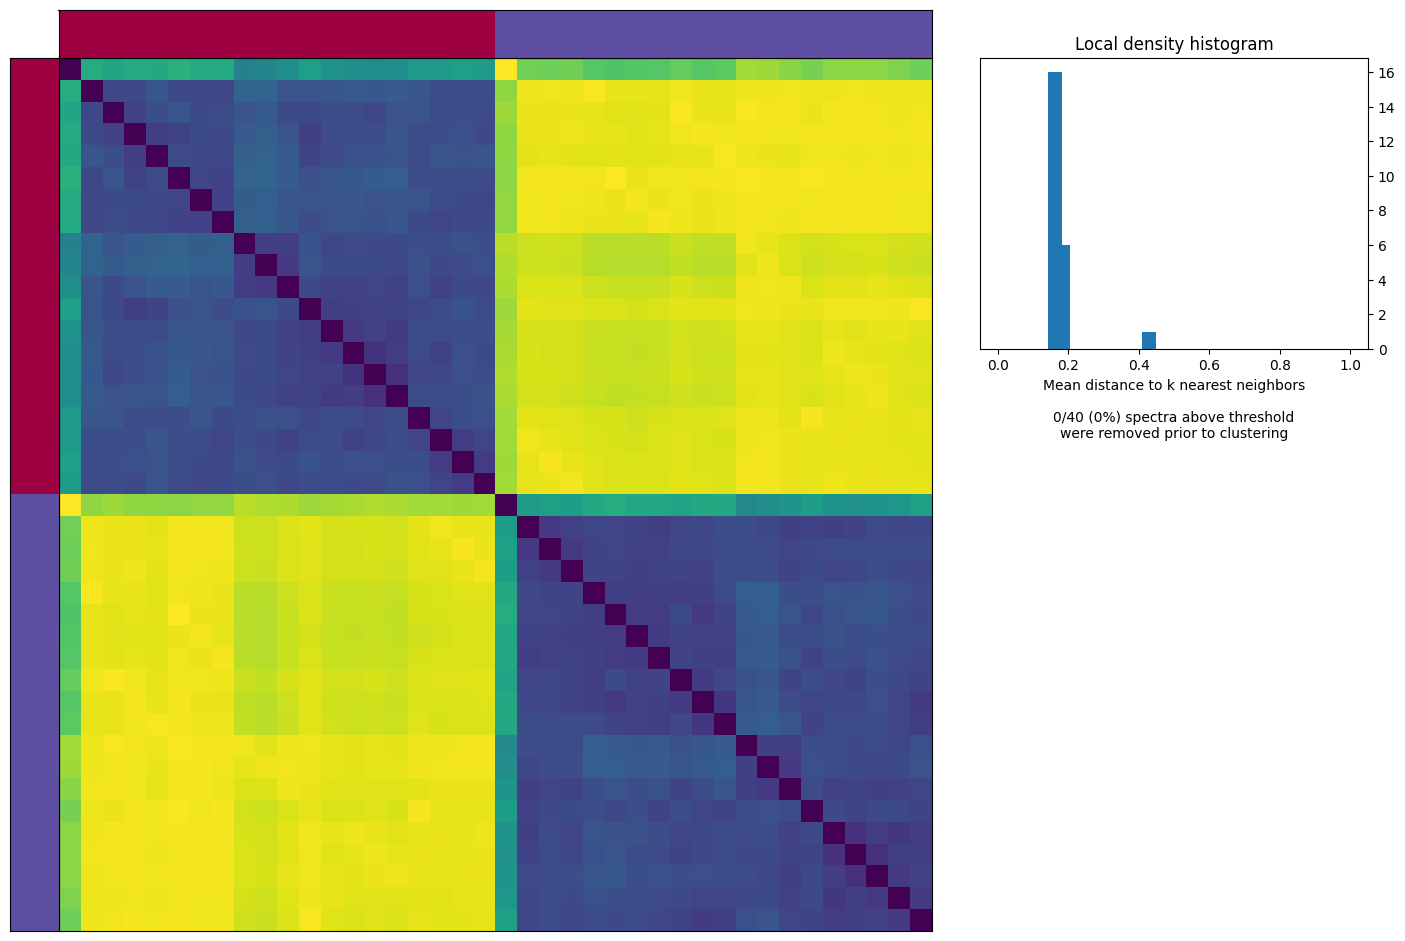

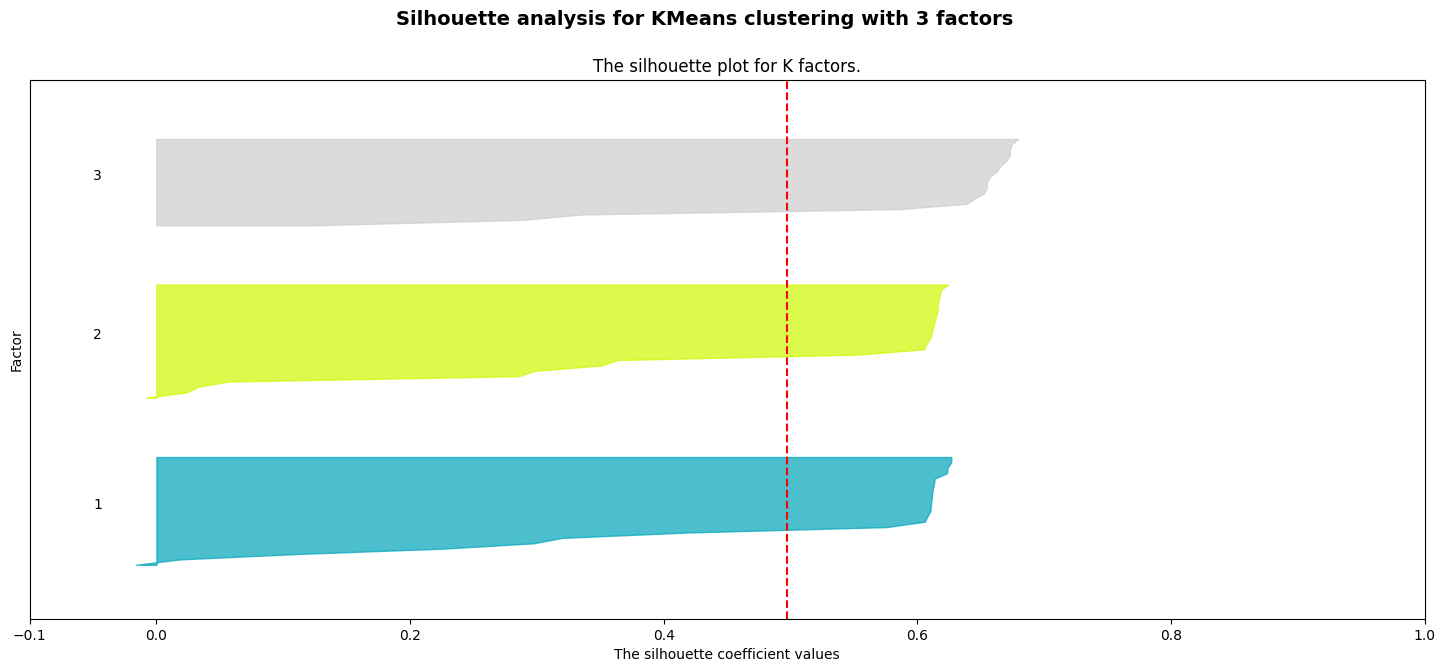

[Iter.    0]  loss:14.503417  pct:100.000000000
[Iter.   10]  loss:3.020639  pct:-79.172914090
[Iter.   20]  loss:3.004627  pct:-0.530083217
[Iter.   30]  loss:2.954885  pct:-1.655514729
[Iter.   40]  loss:2.931783  pct:-0.781834522
[Iter.   50]  loss:2.921448  pct:-0.352498801
[Iter.   60]  loss:2.917668  pct:-0.129390397
[Iter.   70]  loss:2.915651  pct:-0.069146566
[Iter.   80]  loss:2.914593  pct:-0.036268222
[Iter.   90]  loss:2.913988  pct:-0.020777672
[Iter.  100]  loss:2.913571  pct:-0.014295188
[Iter.  110]  loss:2.913314  pct:-0.008820782
[Iter.  120]  loss:2.913154  pct:-0.005485693
converged
New best!
Trial 0 loss: 2.913154
Best loss: 2.913154 (trial 0)
[Iter.    0]  loss:8065.694176  pct:100.000000000
[Iter.   10]  loss:344.393719  pct:-95.730141621
[Iter.   20]  loss:344.312939  pct:-0.023455534
[Iter.   30]  loss:342.449618  pct:-0.541170929
[Iter.   40]  loss:334.472921  pct:-2.329305115
[Iter.   50]  loss:332.258889  pct:-0.661946598
[Iter.   60]  loss:331.198476  pct:

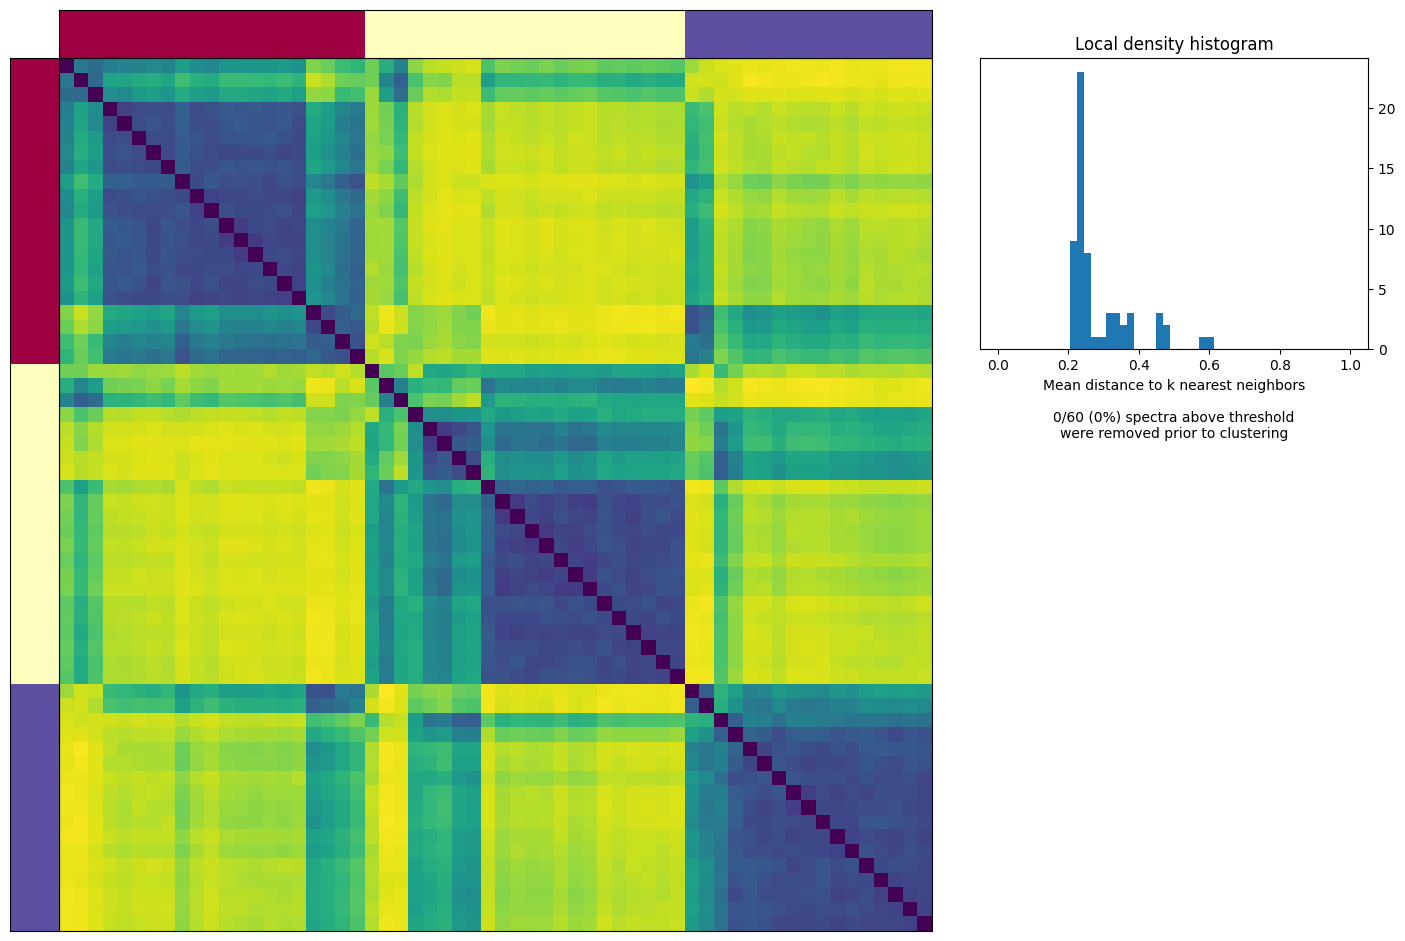

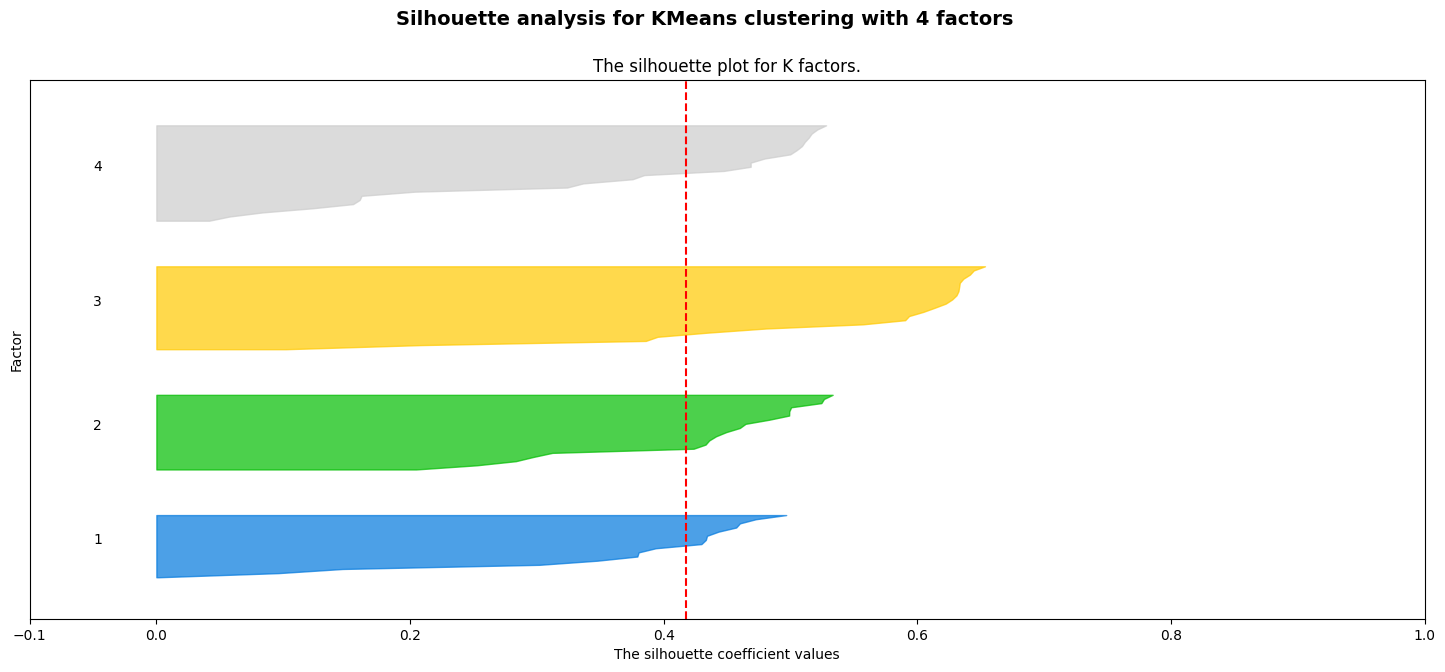

[Iter.    0]  loss:15.137538  pct:100.000000000
[Iter.   10]  loss:3.020251  pct:-80.047940405
[Iter.   20]  loss:3.001919  pct:-0.606962921
[Iter.   30]  loss:2.944865  pct:-1.900583944
[Iter.   40]  loss:2.915696  pct:-0.990481750
[Iter.   50]  loss:2.906202  pct:-0.325637245
[Iter.   60]  loss:2.903220  pct:-0.102596823
[Iter.   70]  loss:2.901768  pct:-0.050011814
[Iter.   80]  loss:2.900935  pct:-0.028704729
[Iter.   90]  loss:2.900366  pct:-0.019609355
[Iter.  100]  loss:2.899917  pct:-0.015494087
[Iter.  110]  loss:2.899633  pct:-0.009778136
[Iter.  120]  loss:2.899400  pct:-0.008041136
converged
New best!
Trial 0 loss: 2.899400
Best loss: 2.899400 (trial 0)
[Iter.    0]  loss:8233.013058  pct:100.000000000
[Iter.   10]  loss:344.394137  pct:-95.816912536
[Iter.   20]  loss:344.346747  pct:-0.013760517
[Iter.   30]  loss:343.212177  pct:-0.329484568
[Iter.   40]  loss:334.806767  pct:-2.449041958
[Iter.   50]  loss:331.054024  pct:-1.120868289
[Iter.   60]  loss:329.520379  pct:

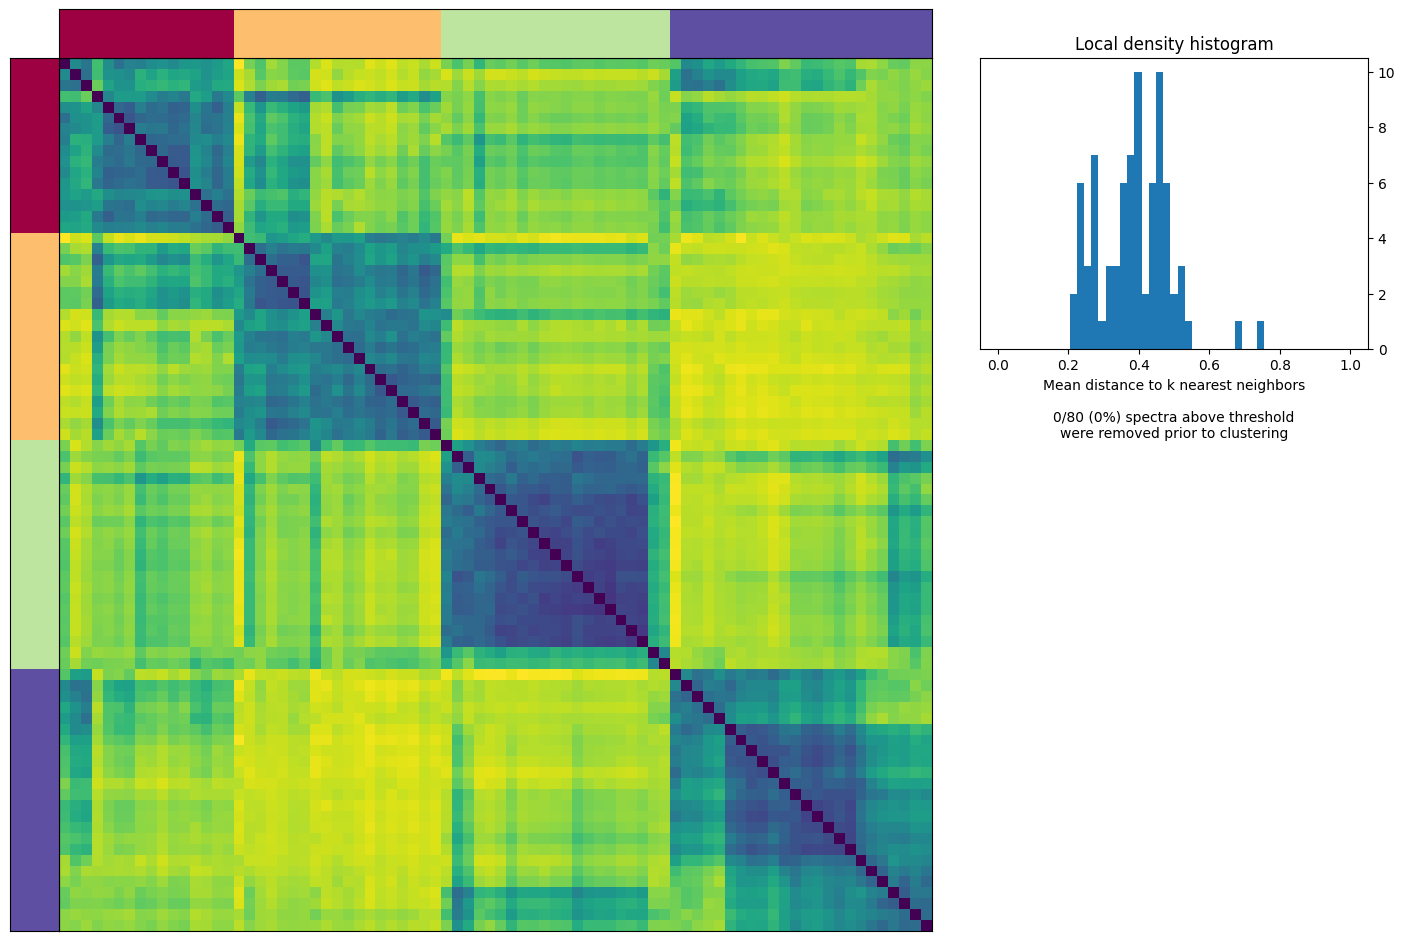

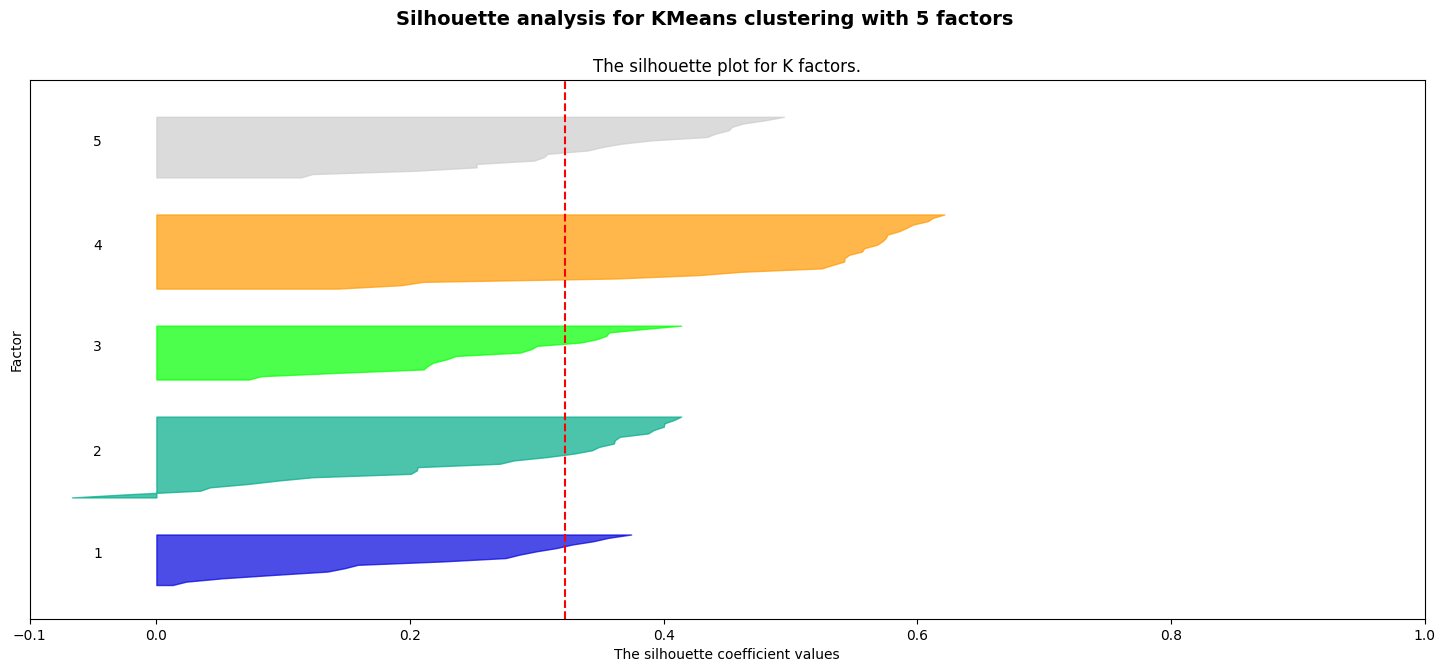

[Iter.    0]  loss:15.694201  pct:100.000000000
[Iter.   10]  loss:3.019853  pct:-80.758161661
[Iter.   20]  loss:3.000942  pct:-0.626219388
[Iter.   30]  loss:2.939581  pct:-2.044712333
[Iter.   40]  loss:2.911387  pct:-0.959124445
[Iter.   50]  loss:2.900140  pct:-0.386301106
[Iter.   60]  loss:2.894252  pct:-0.203032343
[Iter.   70]  loss:2.890864  pct:-0.117051522
[Iter.   80]  loss:2.888587  pct:-0.078791673
[Iter.   90]  loss:2.886856  pct:-0.059917731
[Iter.  100]  loss:2.885626  pct:-0.042592566
[Iter.  110]  loss:2.884633  pct:-0.034409034
[Iter.  120]  loss:2.883786  pct:-0.029371389
[Iter.  130]  loss:2.883111  pct:-0.023408771
[Iter.  140]  loss:2.882597  pct:-0.017820534
[Iter.  150]  loss:2.882159  pct:-0.015189100
[Iter.  160]  loss:2.881780  pct:-0.013165940
[Iter.  170]  loss:2.881419  pct:-0.012520733
[Iter.  180]  loss:2.881101  pct:-0.011034295
[Iter.  190]  loss:2.880900  pct:-0.006994449
[Iter.  200]  loss:2.880670  pct:-0.007956754
converged
New best!
Trial 0 los

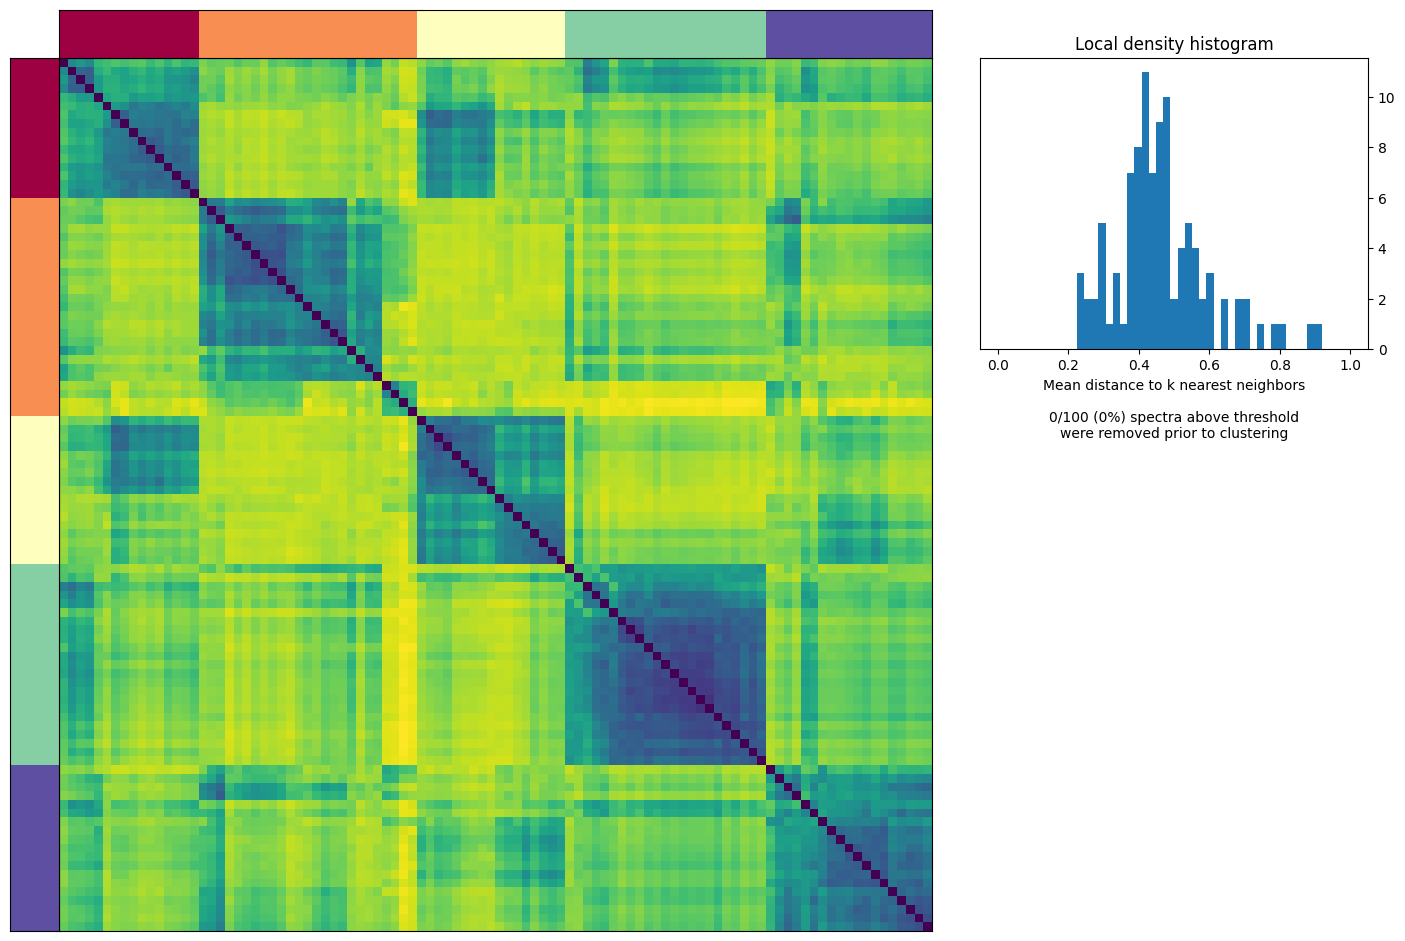

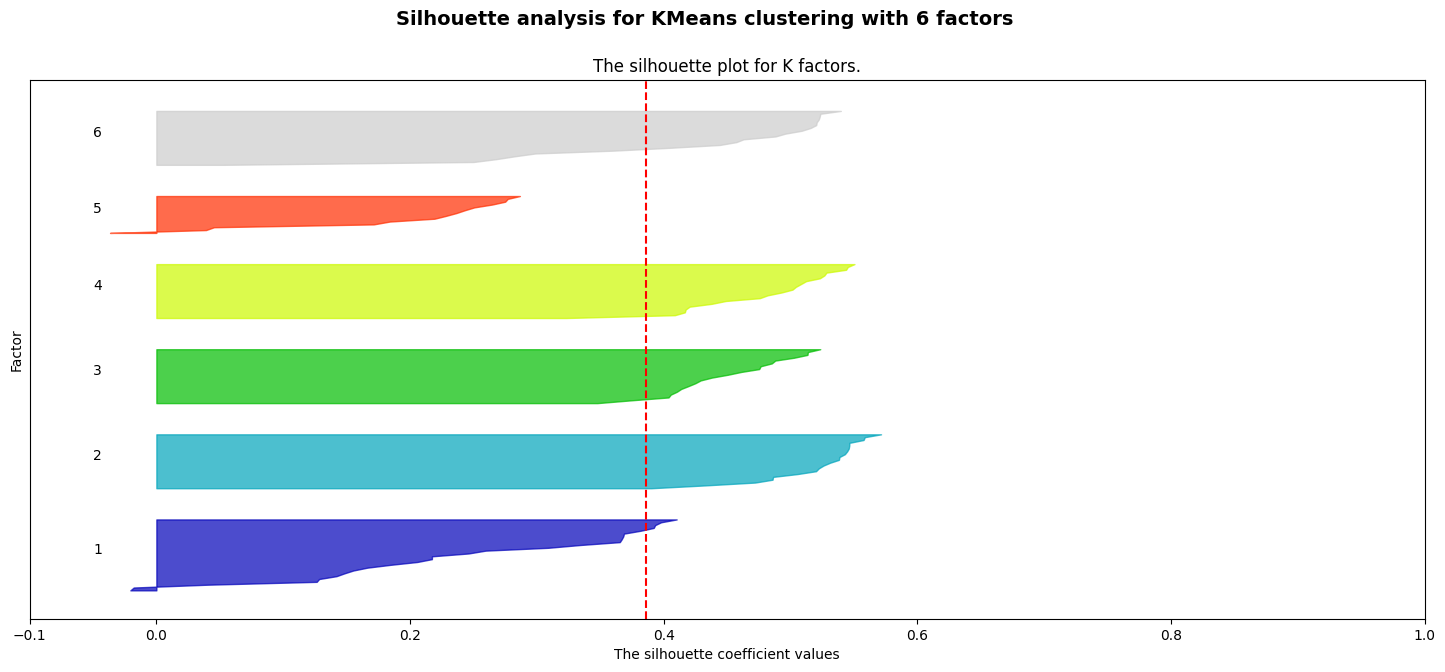

[Iter.    0]  loss:16.174235  pct:100.000000000
[Iter.   10]  loss:3.019104  pct:-81.333866309
[Iter.   20]  loss:2.999272  pct:-0.656899646
[Iter.   30]  loss:2.921221  pct:-2.602334091
[Iter.   40]  loss:2.890082  pct:-1.065965973
[Iter.   50]  loss:2.880522  pct:-0.330777245
[Iter.   60]  loss:2.876103  pct:-0.153392636
[Iter.   70]  loss:2.873599  pct:-0.087071889
[Iter.   80]  loss:2.872103  pct:-0.052048706
[Iter.   90]  loss:2.871182  pct:-0.032089280
[Iter.  100]  loss:2.870506  pct:-0.023528285
[Iter.  110]  loss:2.870054  pct:-0.015743306
[Iter.  120]  loss:2.869741  pct:-0.010926623
[Iter.  130]  loss:2.869533  pct:-0.007246329
[Iter.  140]  loss:2.869378  pct:-0.005383289
converged
New best!
Trial 0 loss: 2.869378
Best loss: 2.869378 (trial 0)
[Iter.    0]  loss:8493.849932  pct:100.000000000
[Iter.   10]  loss:344.388952  pct:-95.945431639
[Iter.   20]  loss:344.214175  pct:-0.050749972
[Iter.   30]  loss:341.133343  pct:-0.895033380
[Iter.   40]  loss:331.943936  pct:-2.6

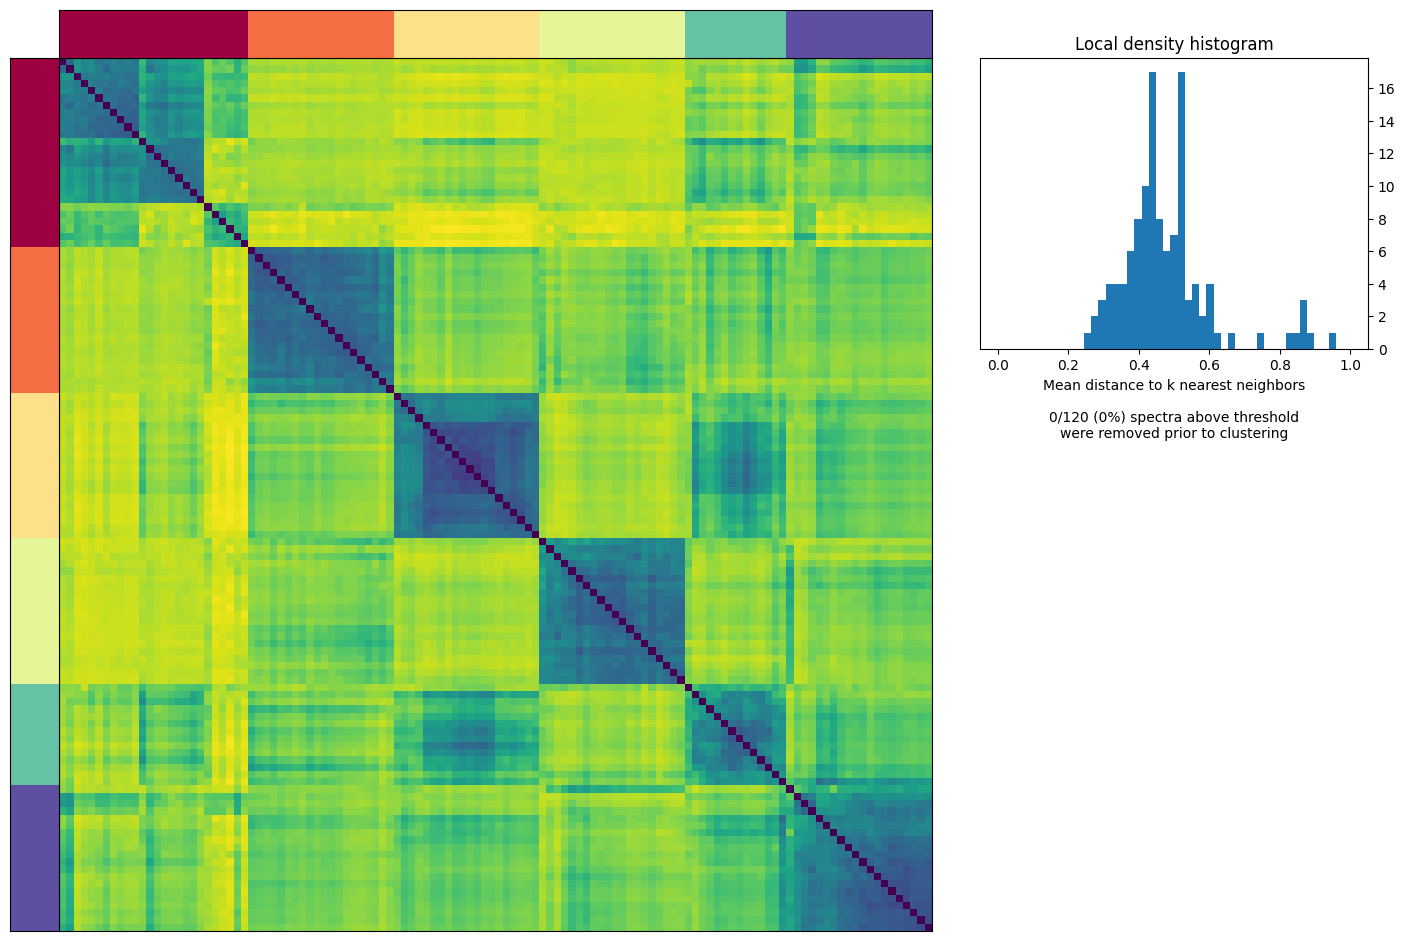

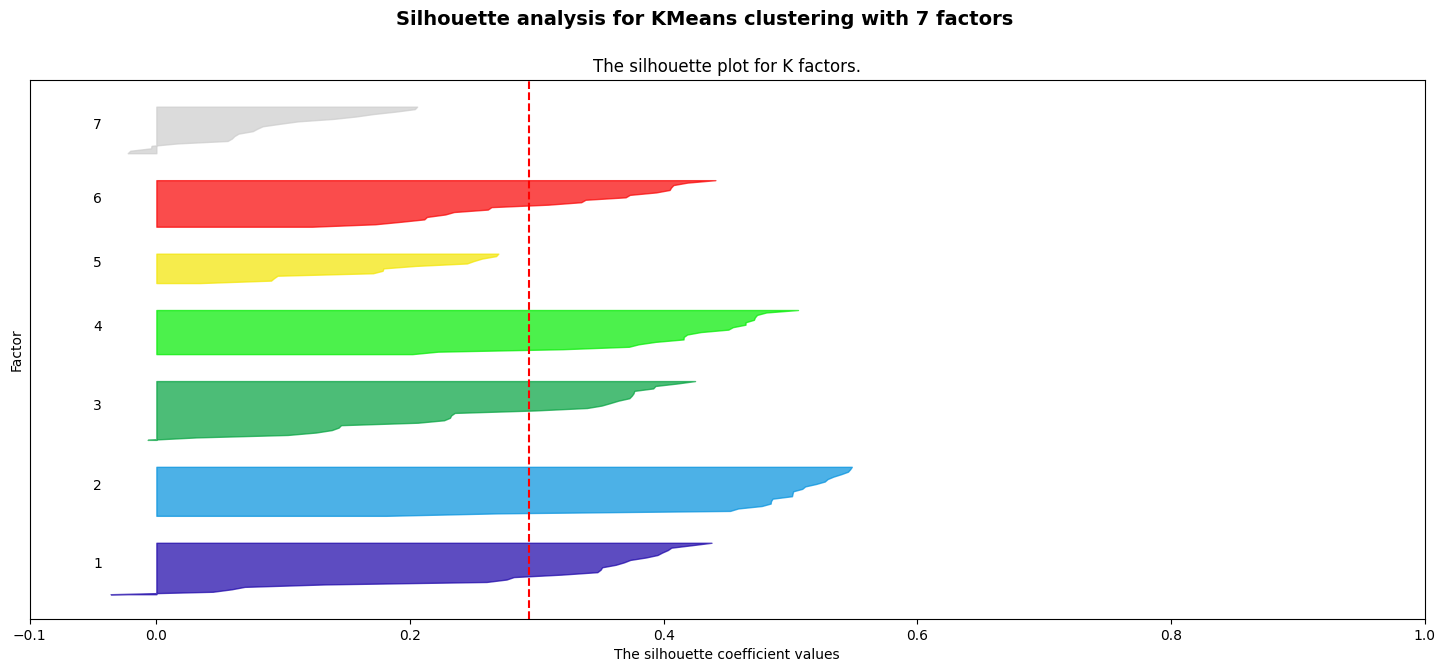

[Iter.    0]  loss:16.602071  pct:100.000000000
[Iter.   10]  loss:3.018835  pct:-81.816513027
[Iter.   20]  loss:2.995124  pct:-0.785444262
[Iter.   30]  loss:2.914094  pct:-2.705417867
[Iter.   40]  loss:2.880363  pct:-1.157490607
[Iter.   50]  loss:2.869155  pct:-0.389127743
[Iter.   60]  loss:2.864018  pct:-0.179040807
[Iter.   70]  loss:2.861162  pct:-0.099721088
[Iter.   80]  loss:2.859443  pct:-0.060082903
[Iter.   90]  loss:2.858315  pct:-0.039432446
[Iter.  100]  loss:2.857525  pct:-0.027658194
[Iter.  110]  loss:2.856987  pct:-0.018819639
[Iter.  120]  loss:2.856593  pct:-0.013802340
[Iter.  130]  loss:2.856339  pct:-0.008864828
[Iter.  140]  loss:2.856163  pct:-0.006171585
converged
New best!
Trial 0 loss: 2.856163
Best loss: 2.856163 (trial 0)
[Iter.    0]  loss:8604.463572  pct:100.000000000
[Iter.   10]  loss:344.392119  pct:-95.997517849
[Iter.   20]  loss:344.328066  pct:-0.018598674
[Iter.   30]  loss:342.758428  pct:-0.455855476
[Iter.   40]  loss:334.960186  pct:-2.2

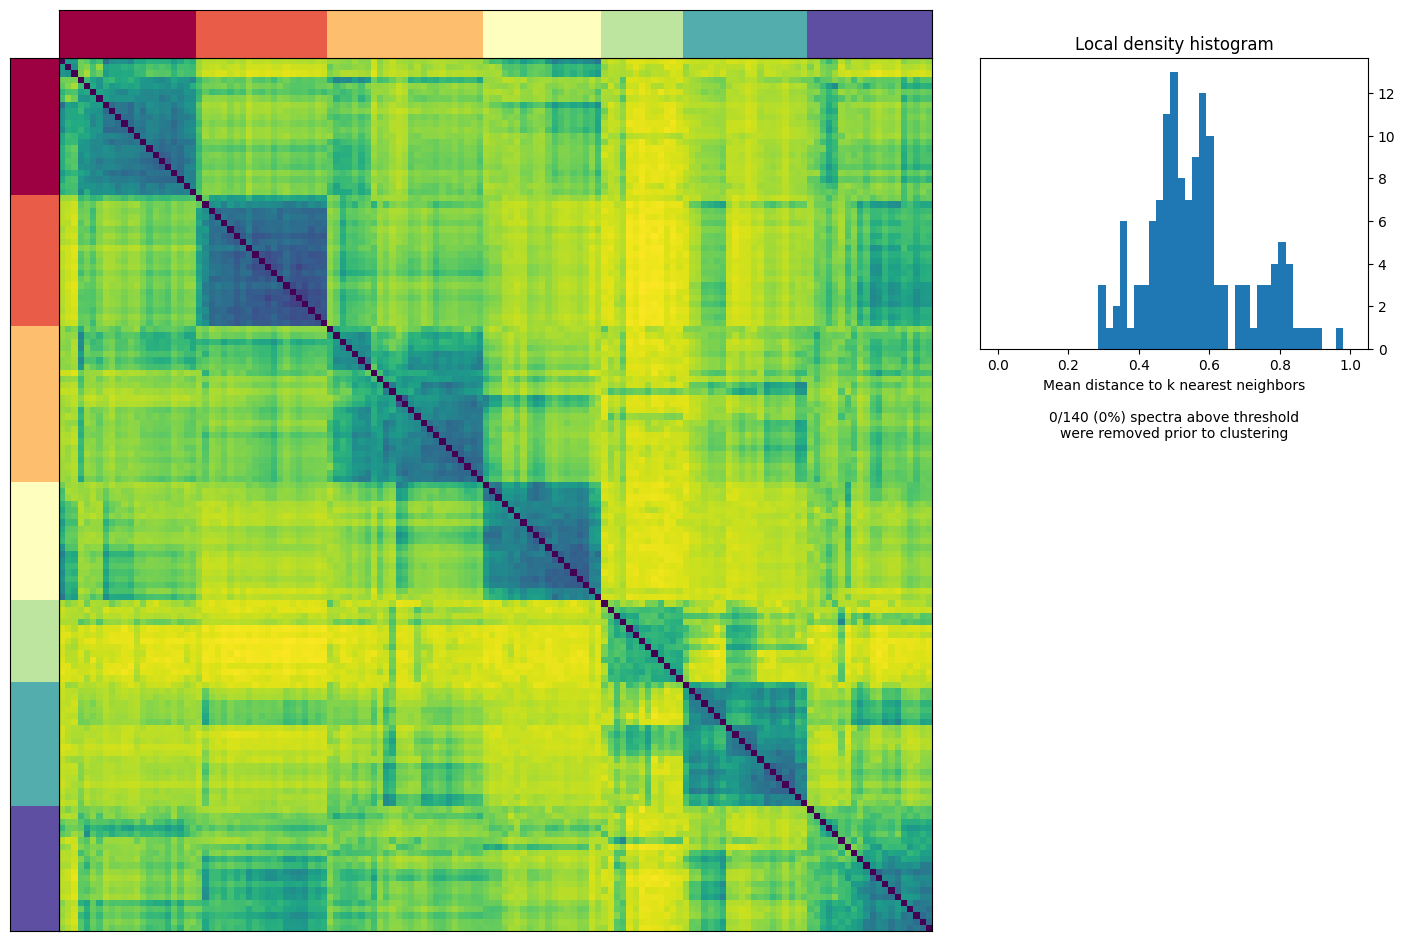

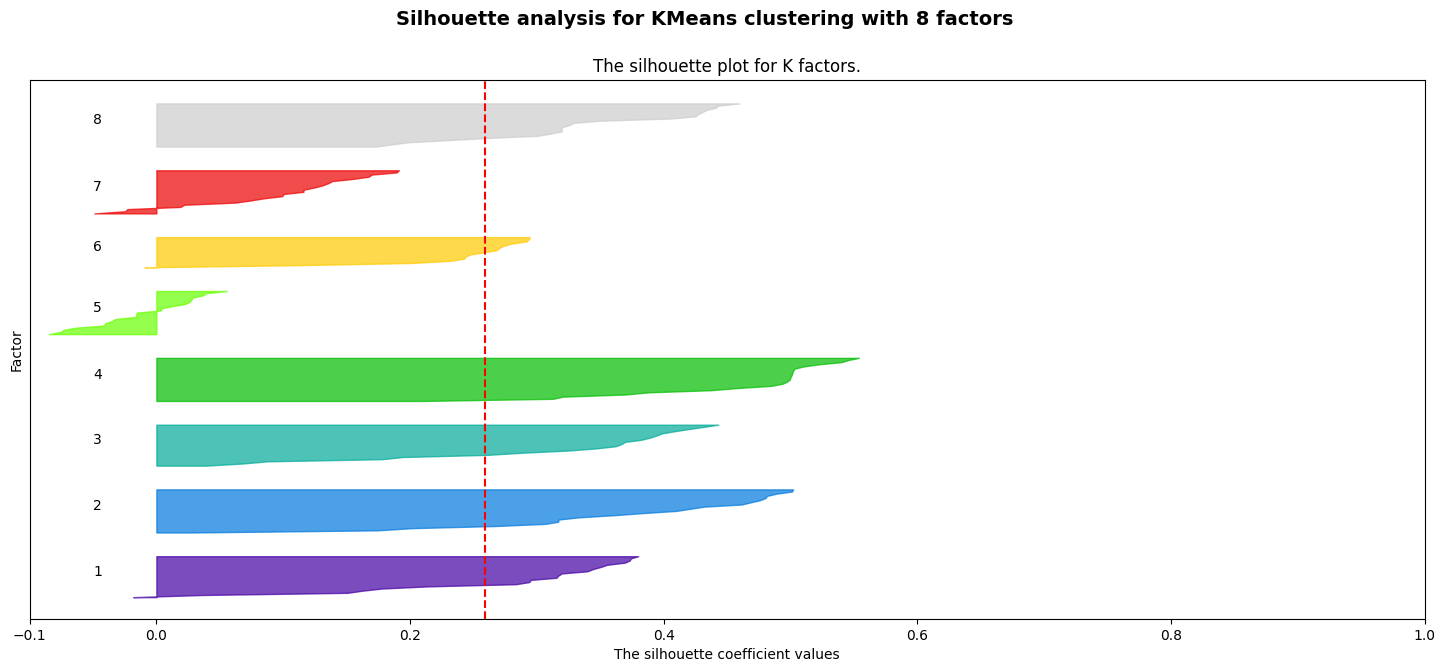

[Iter.    0]  loss:16.987865  pct:100.000000000
[Iter.   10]  loss:3.018390  pct:-82.232081882
[Iter.   20]  loss:2.993714  pct:-0.817538352
[Iter.   30]  loss:2.902868  pct:-3.034543378
[Iter.   40]  loss:2.874600  pct:-0.973811483
[Iter.   50]  loss:2.865256  pct:-0.325044130
[Iter.   60]  loss:2.860540  pct:-0.164587803
[Iter.   70]  loss:2.857552  pct:-0.104445298
[Iter.   80]  loss:2.855668  pct:-0.065944969
[Iter.   90]  loss:2.854368  pct:-0.045507160
[Iter.  100]  loss:2.853371  pct:-0.034954652
[Iter.  110]  loss:2.852652  pct:-0.025194652
[Iter.  120]  loss:2.852123  pct:-0.018546048
[Iter.  130]  loss:2.851709  pct:-0.014501946
[Iter.  140]  loss:2.851461  pct:-0.008708066
[Iter.  150]  loss:2.851281  pct:-0.006309026
converged
New best!
Trial 0 loss: 2.851281
Best loss: 2.851281 (trial 0)
[Iter.    0]  loss:8699.971940  pct:100.000000000
[Iter.   10]  loss:344.391502  pct:-96.041464223
[Iter.   20]  loss:344.304897  pct:-0.025147212
[Iter.   30]  loss:342.238868  pct:-0.600

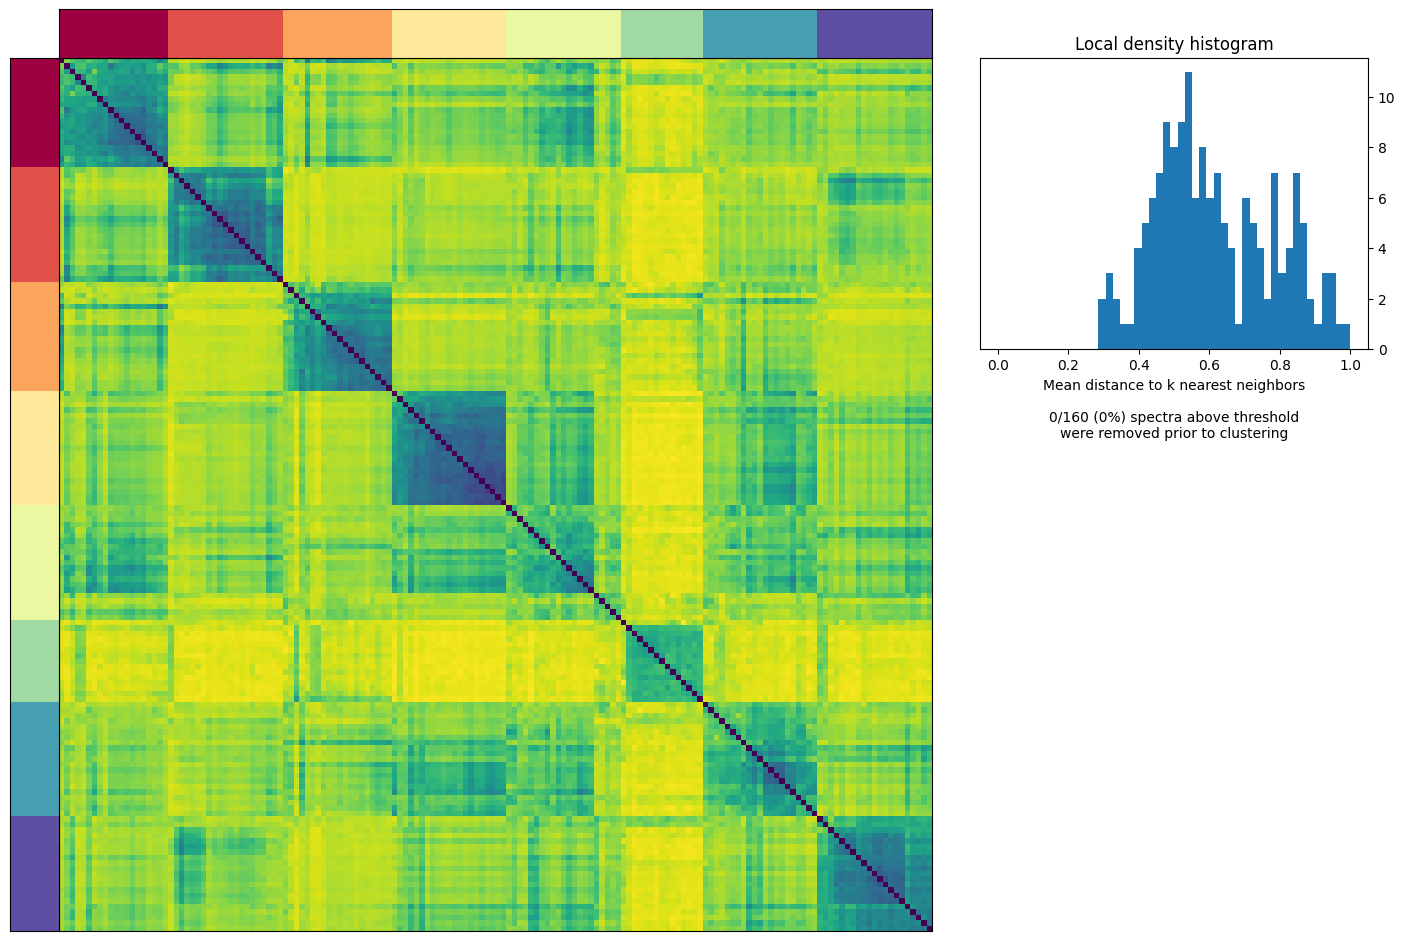

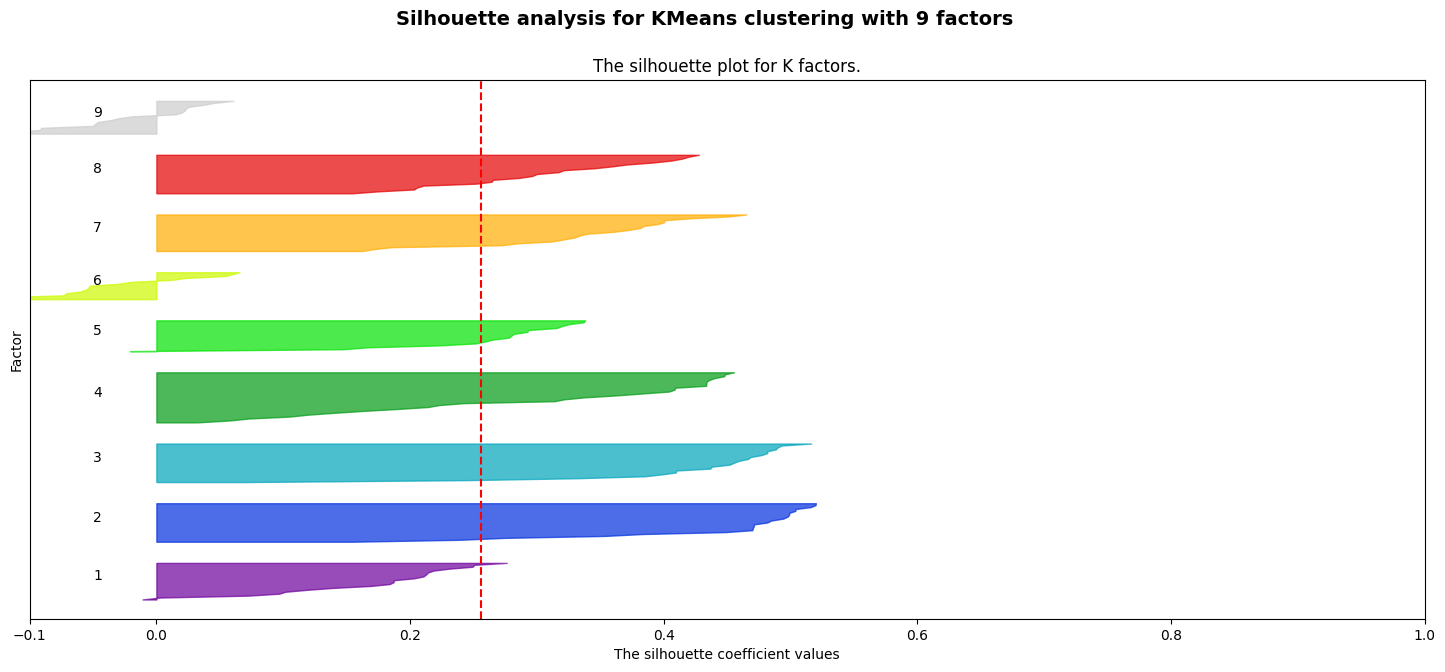

[Iter.    0]  loss:17.319489  pct:100.000000000
[Iter.   10]  loss:3.018363  pct:-82.572446930
[Iter.   20]  loss:2.996507  pct:-0.724114556
[Iter.   30]  loss:2.915013  pct:-2.719619537
[Iter.   40]  loss:2.872572  pct:-1.455951720
[Iter.   50]  loss:2.857805  pct:-0.514055675
[Iter.   60]  loss:2.851313  pct:-0.227169383
[Iter.   70]  loss:2.847846  pct:-0.121604813
[Iter.   80]  loss:2.845766  pct:-0.073034657
[Iter.   90]  loss:2.844515  pct:-0.043953910
[Iter.  100]  loss:2.843685  pct:-0.029202976
[Iter.  110]  loss:2.842949  pct:-0.025855944
[Iter.  120]  loss:2.842375  pct:-0.020199051
[Iter.  130]  loss:2.841946  pct:-0.015085687
[Iter.  140]  loss:2.841662  pct:-0.009997739
[Iter.  150]  loss:2.841386  pct:-0.009704861
converged
New best!
Trial 0 loss: 2.841386
Best loss: 2.841386 (trial 0)
[Iter.    0]  loss:8787.983927  pct:100.000000000
[Iter.   10]  loss:344.390687  pct:-96.081118376
[Iter.   20]  loss:344.293016  pct:-0.028360494
[Iter.   30]  loss:341.980352  pct:-0.671

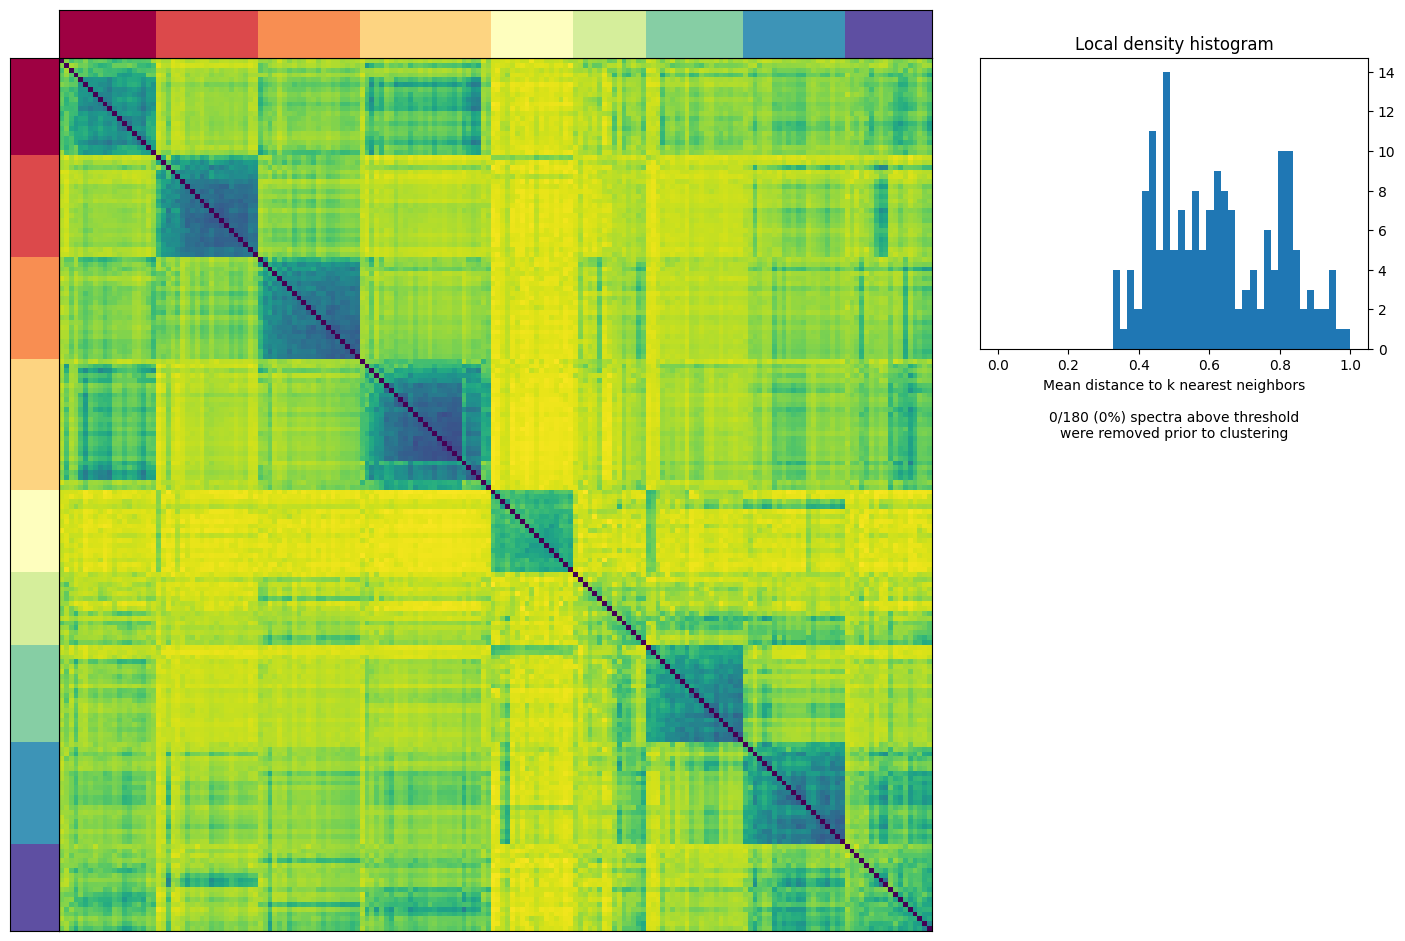

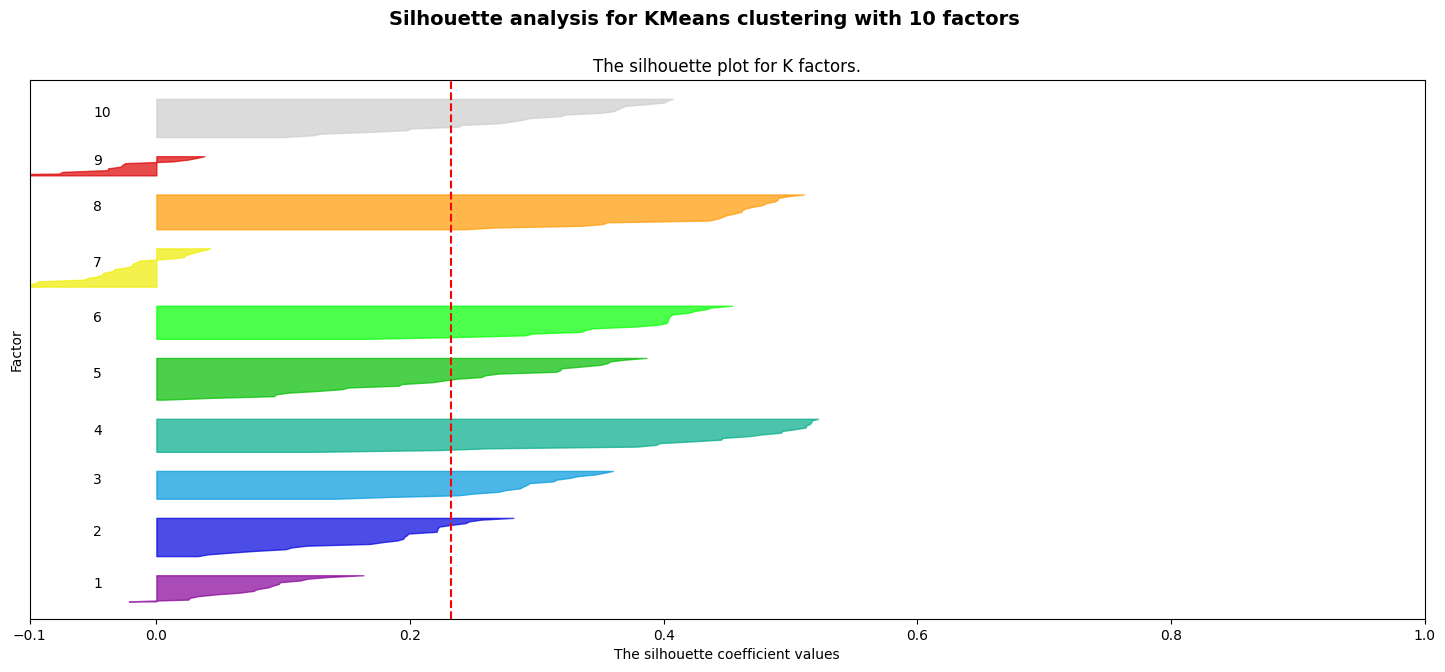

[Iter.    0]  loss:17.628233  pct:100.000000000
[Iter.   10]  loss:3.018242  pct:-82.878363655
[Iter.   20]  loss:2.995699  pct:-0.746877692
[Iter.   30]  loss:2.906606  pct:-2.974043879
[Iter.   40]  loss:2.865066  pct:-1.429162358
[Iter.   50]  loss:2.850481  pct:-0.509060903
[Iter.   60]  loss:2.843975  pct:-0.228252617
[Iter.   70]  loss:2.840461  pct:-0.123538049
[Iter.   80]  loss:2.838372  pct:-0.073546030
[Iter.   90]  loss:2.837129  pct:-0.043790408
[Iter.  100]  loss:2.836311  pct:-0.028838126
[Iter.  110]  loss:2.835753  pct:-0.019674162
[Iter.  120]  loss:2.835319  pct:-0.015291609
[Iter.  130]  loss:2.835012  pct:-0.010841127
[Iter.  140]  loss:2.834768  pct:-0.008592945
[Iter.  150]  loss:2.834562  pct:-0.007275206
converged
New best!
Trial 0 loss: 2.834562
Best loss: 2.834562 (trial 0)
[Iter.    0]  loss:8867.933701  pct:100.000000000
[Iter.   10]  loss:344.390695  pct:-96.116449366
[Iter.   20]  loss:344.296297  pct:-0.027410149
[Iter.   30]  loss:342.337779  pct:-0.568

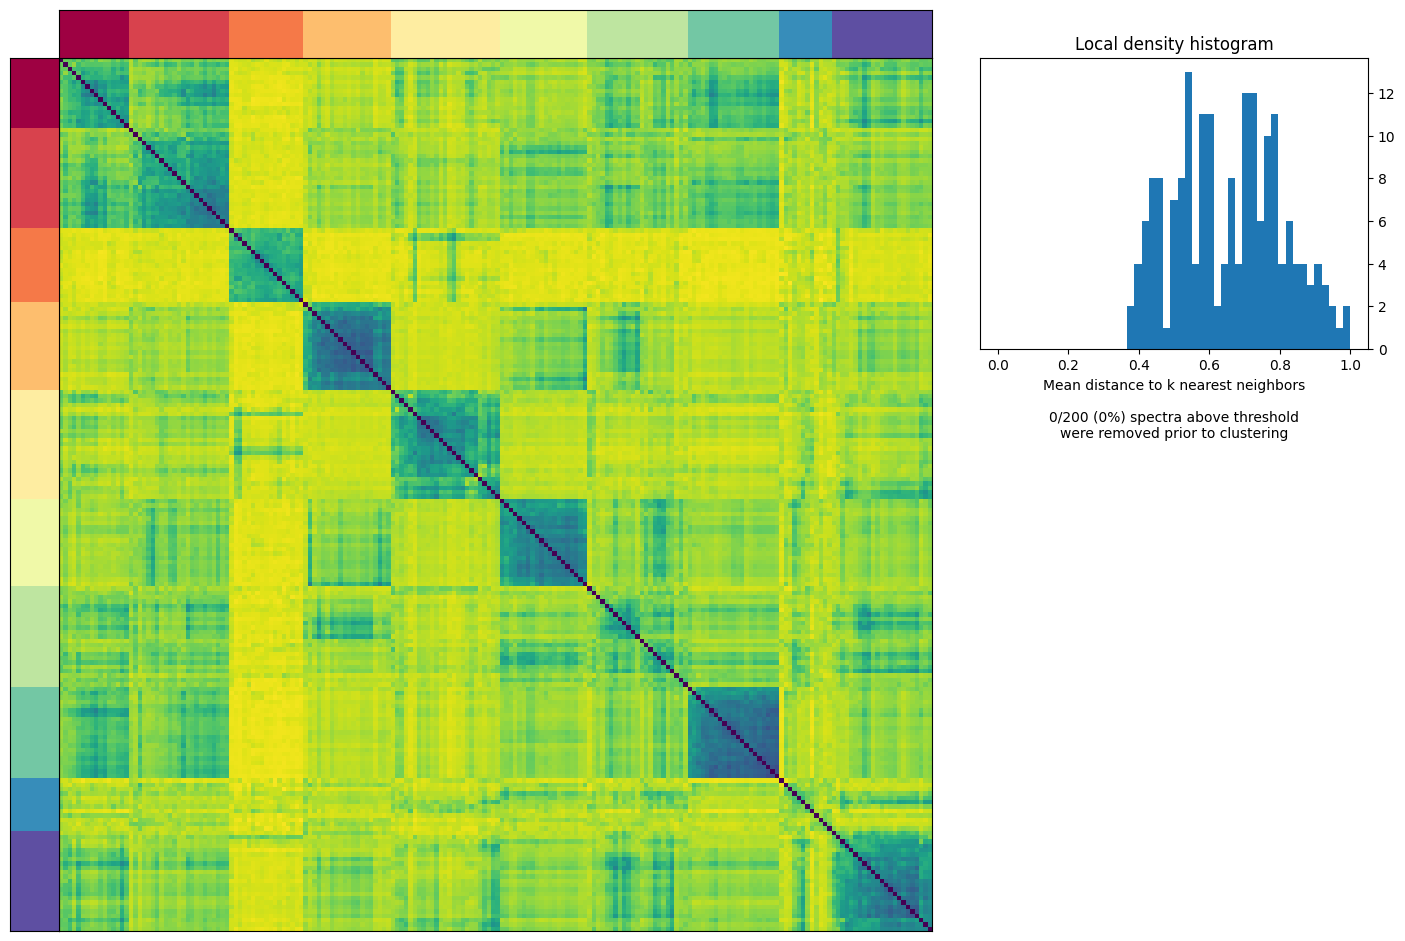

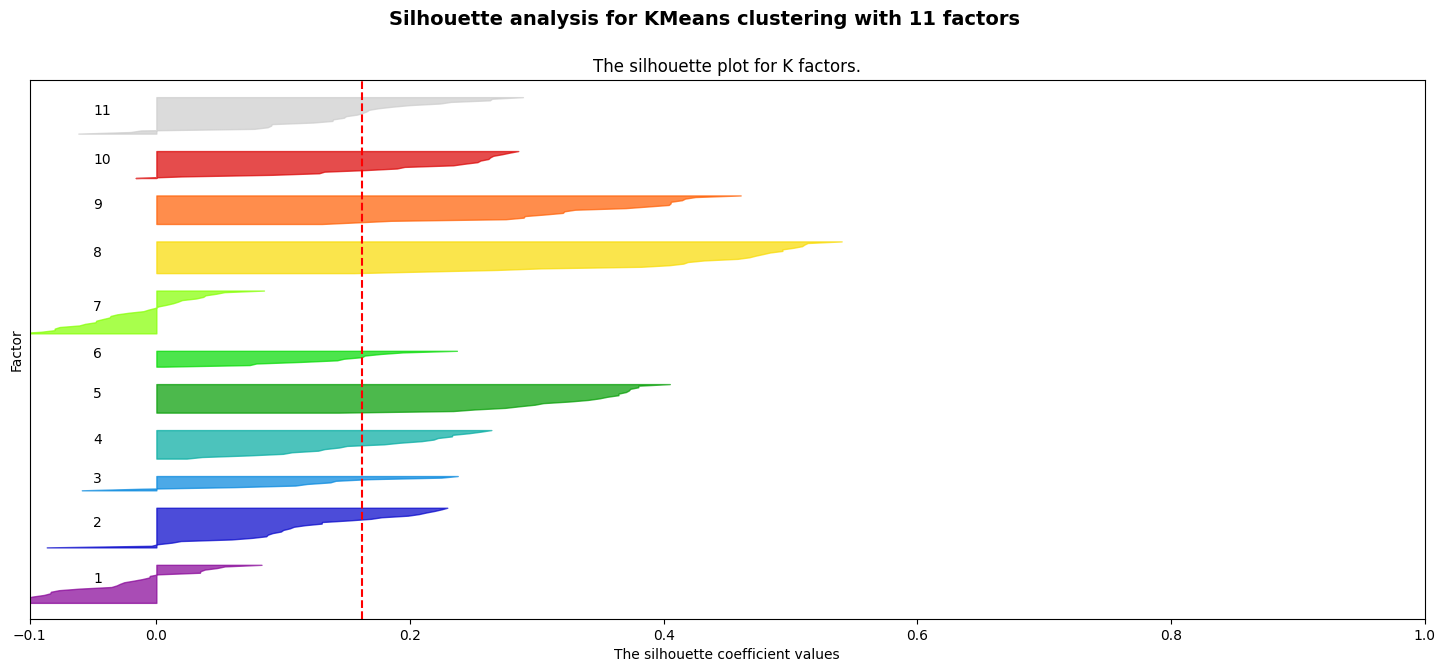

[Iter.    0]  loss:17.932626  pct:100.000000000
[Iter.   10]  loss:3.017989  pct:-83.170401617
[Iter.   20]  loss:2.991744  pct:-0.869624155
[Iter.   30]  loss:2.886586  pct:-3.514930130
[Iter.   40]  loss:2.853973  pct:-1.129800231
[Iter.   50]  loss:2.841752  pct:-0.428238820
[Iter.   60]  loss:2.835840  pct:-0.208021839
[Iter.   70]  loss:2.832418  pct:-0.120675064
[Iter.   80]  loss:2.830297  pct:-0.074864490
[Iter.   90]  loss:2.828952  pct:-0.047537852
[Iter.  100]  loss:2.827953  pct:-0.035297607
[Iter.  110]  loss:2.827275  pct:-0.023997879
[Iter.  120]  loss:2.826727  pct:-0.019386657
[Iter.  130]  loss:2.826381  pct:-0.012225244
[Iter.  140]  loss:2.826138  pct:-0.008603596
[Iter.  150]  loss:2.825949  pct:-0.006701802
converged
New best!
Trial 0 loss: 2.825949
Best loss: 2.825949 (trial 0)
[Iter.    0]  loss:8935.090785  pct:100.000000000
[Iter.   10]  loss:344.390494  pct:-96.145640794
[Iter.   20]  loss:344.307145  pct:-0.024201836
[Iter.   30]  loss:342.876976  pct:-0.415

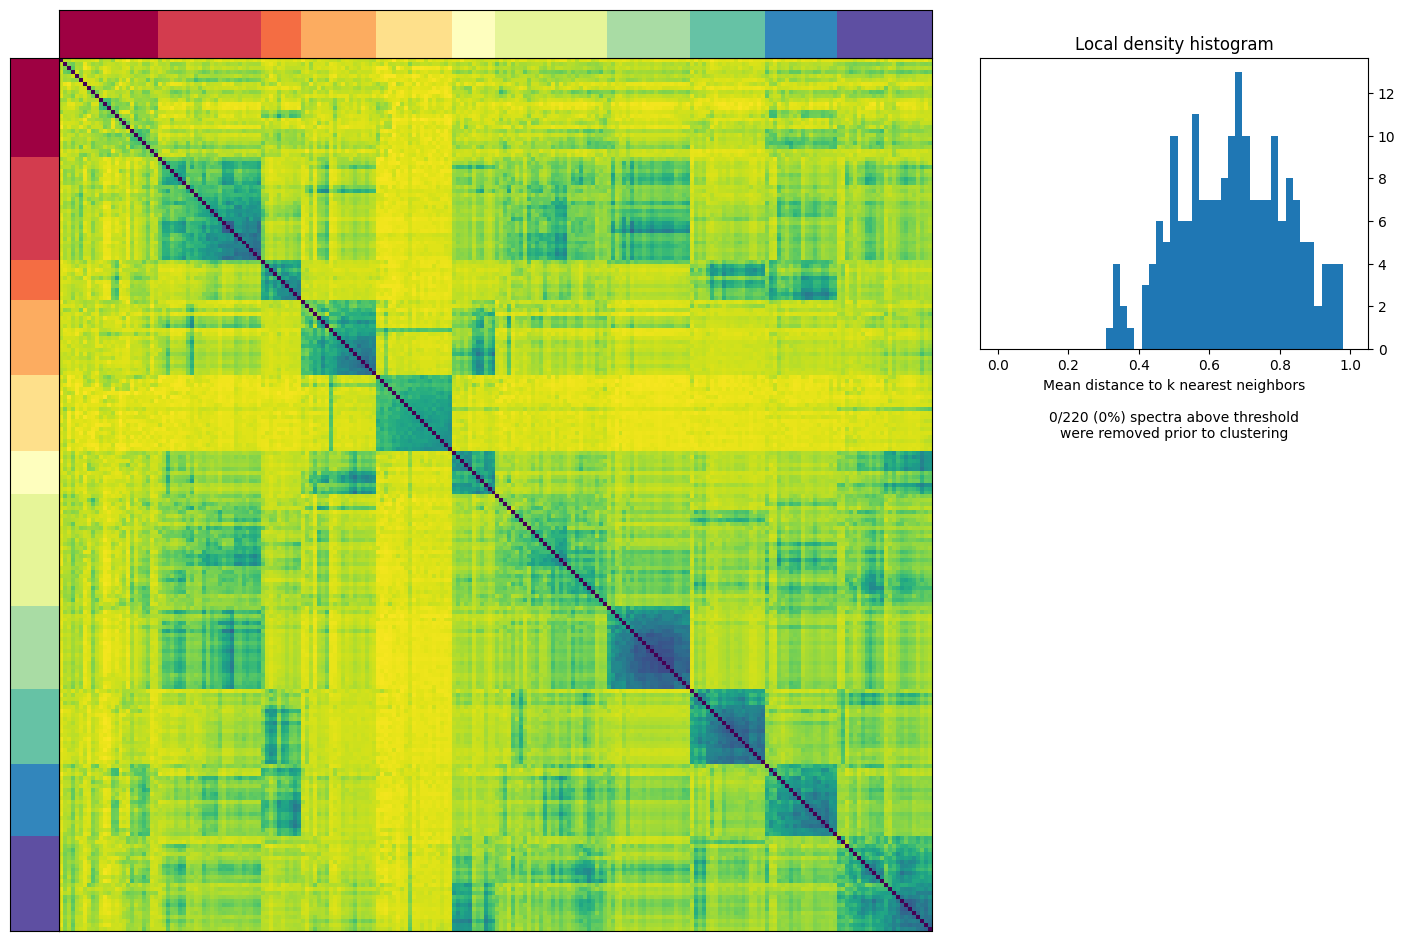

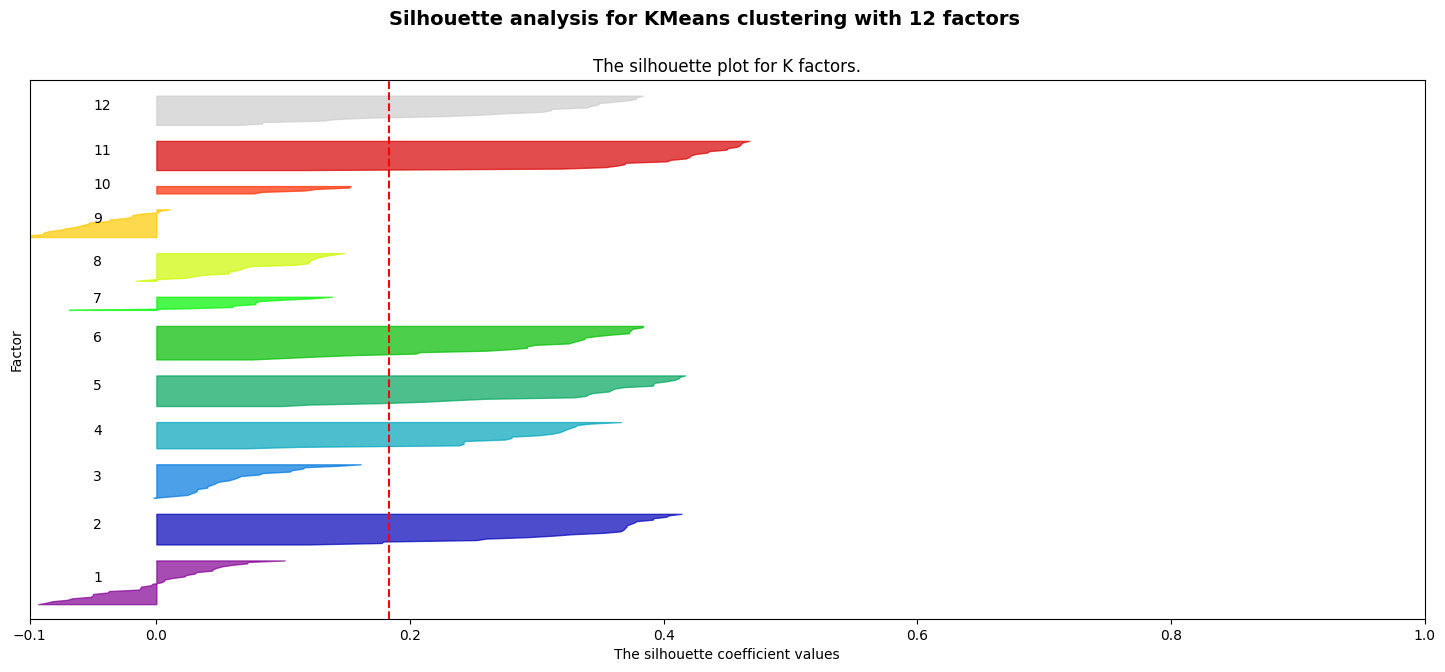

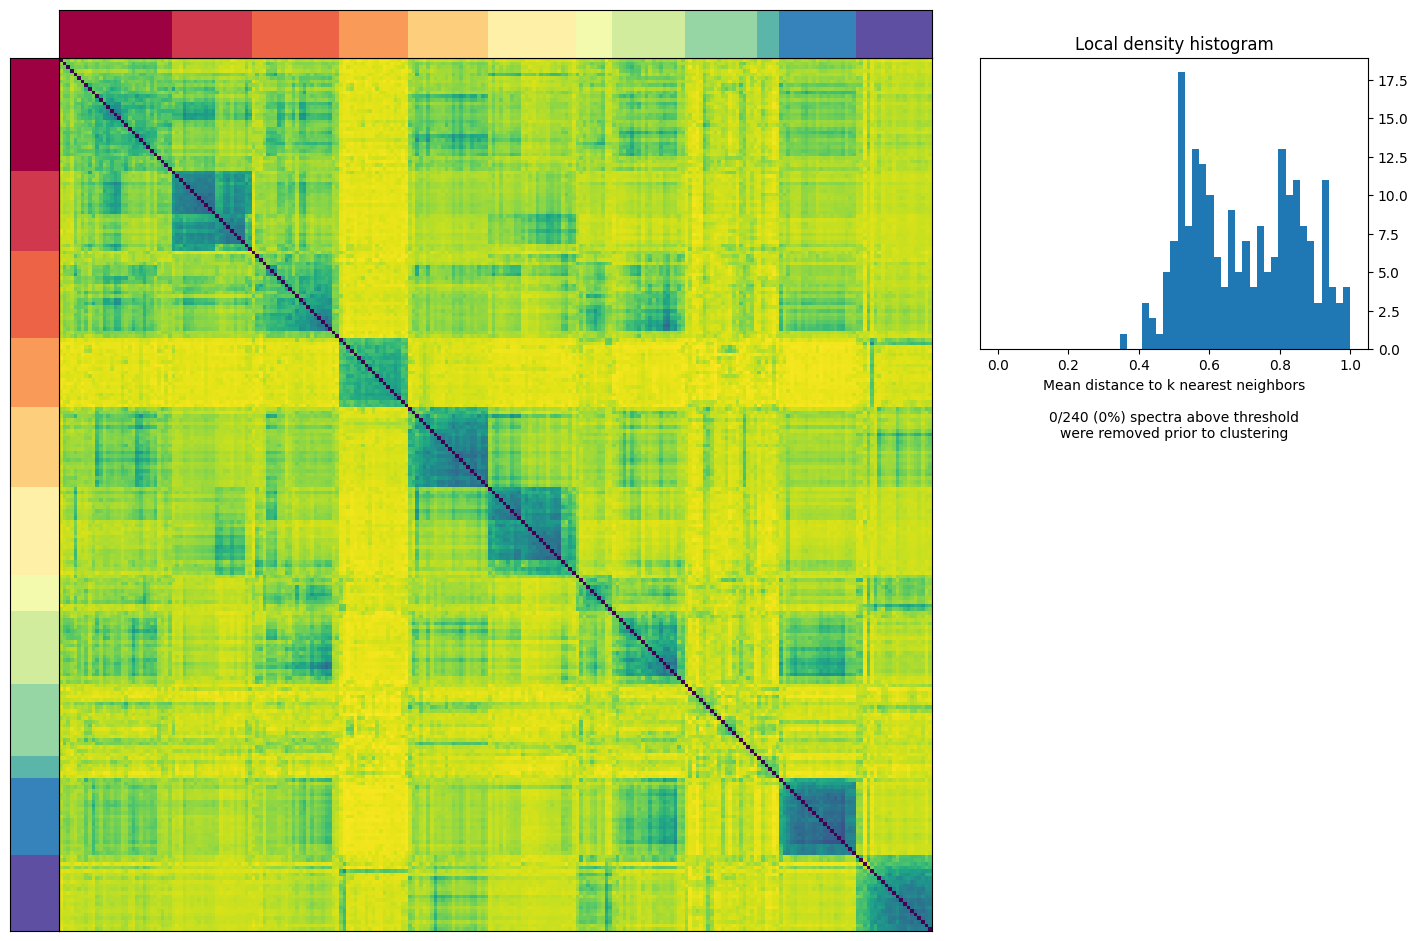

In [ ]:
# cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

n_top_genes = 20
density_threshold = 2

run_params = sccHPF.load_df_from_npz(cnmf_obj.paths['nmf_parameters'])

# retrieve the consensus for each k value and save the files
for k in ks:
    merged_spectra = sccHPF.load_df_from_npz(cnmf_obj.paths['merged_spectra']%k)
    cnmf_obj.consensus(k, str(density_threshold), show_clustering = True, close_clustergram_fig=False)

    # usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=i, density_threshold=density_threshold)
    scorefn = cnmf_obj.paths['gene_spectra_score__txt'] % (k, str(density_threshold).replace('.', '_'))
    tpmfn = cnmf_obj.paths['gene_spectra_tpm__txt'] % (k, str(density_threshold).replace('.', '_'))
    usagefn = cnmf_obj.paths['consensus_usages__txt'] % (k, str(density_threshold).replace('.', '_'))
    spectra_scores = pd.read_csv(scorefn, sep='\t', index_col=0).T
    spectra_tpm = pd.read_csv(tpmfn, sep='\t', index_col=0).T

    usage = pd.read_csv(usagefn, sep='\t', index_col=0)
    usage = usage.div(usage.sum(axis=1), axis=0)

    try:
        usage.columns = [int(x) for x in usage.columns]
    except:
        print('Usage matrix columns include non integer values')

    top_genes = []
    for gep in spectra_scores.columns:
        top_genes.append(list(spectra_scores.sort_values(by=gep, ascending=False).index[:n_top_genes]))

    top_genes = pd.DataFrame(top_genes, index=spectra_scores.columns).T
    usage_norm, gep_scores, gep_tpm, topgenes = usage, spectra_scores, spectra_tpm, top_genes

    if not os.path.exists("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/" % k):
      os.mkdir("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/" % k)
    usage_norm.to_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/usage_norm.csv" % k)

    if not os.path.exists("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/" % k):
      os.mkdir("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/" % k)
    gep_scores.to_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/gep_scores.csv" % k)

    if not os.path.exists("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/" % k):
      os.mkdir("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/" % k)
    gep_tpm.to_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/gep_tpm.csv" % k)

    if not os.path.exists("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/" % k):
      os.mkdir("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/" % k)
    topgenes.to_csv("/content/drive/My Drive/PhD/Research/RG Factor Analysis/sccHPF/basal_BT333_sccHPF/%d/topgenes.csv" % k)

[Iter.    0]  loss:12.603752  pct:100.000000000
[Iter.   10]  loss:3.021867  pct:-76.024064884
[Iter.   20]  loss:3.013731  pct:-0.269237387
[Iter.   30]  loss:2.980508  pct:-1.102402658
[Iter.   40]  loss:2.976177  pct:-0.145290716
[Iter.   50]  loss:2.974954  pct:-0.041120455
[Iter.   60]  loss:2.974237  pct:-0.024078584
[Iter.   70]  loss:2.973762  pct:-0.015984520
[Iter.   80]  loss:2.973433  pct:-0.011043840
[Iter.   90]  loss:2.973200  pct:-0.007852355
[Iter.  100]  loss:2.973055  pct:-0.004873021
converged
New best!
Trial 0 loss: 2.973055
Best loss: 2.973055 (trial 0)
[Iter.    0]  loss:13.688815  pct:100.000000000
[Iter.   10]  loss:3.021453  pct:-77.927580997
[Iter.   20]  loss:3.013819  pct:-0.252654492
[Iter.   30]  loss:2.967073  pct:-1.551048960
[Iter.   40]  loss:2.943682  pct:-0.788367510
[Iter.   50]  loss:2.939582  pct:-0.139256172
[Iter.   60]  loss:2.938136  pct:-0.049198508
[Iter.   70]  loss:2.937424  pct:-0.024252188
[Iter.   80]  loss:2.937145  pct:-0.009485784
[

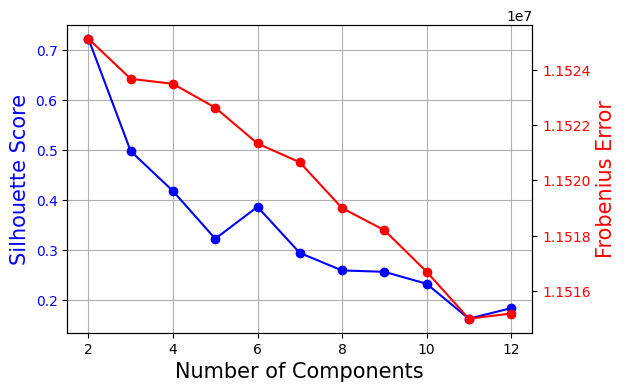

In [ ]:
# k_selection_plot

cnmf_obj.k_selection_plot(close_fig=False)

# Large Drug Screen: Upload Data (run from Ginsburg)

In [ ]:
large_adata = sc.read_mtx(
    'LargeDrugScreen/cds_expgenes_allcells.mtx'
)

large_genelist = pd.read_csv("LargeDrugScreen/expressed_genes_short_name.txt",
                       sep=' ',
                       header = None)

large_adata.var_names = large_genelist.values[:,0]
large_adata.var_names_make_unique()

large_adata

AnnData object with n_obs × n_vars = 144355 × 11534

In [ ]:
filename = 'LargeDrugScreen/drug_name.tsv'
drug_name = pd.read_csv(filename, header=None)

large_adata.obs['drug_name'] = drug_name.values
large_adata.obs['drug_name']

0                             DMSO
1         Epigallocatechin-Gallate
2                      Saracatinib
3                         Icotinib
4                              PBS
                    ...           
144350                 Lifirafenib
144351                     DZD9008
144352                        DMSO
144353                      WZ3146
144354                 Panitumumab
Name: drug_name, Length: 144355, dtype: object

In [ ]:
# Filter out cells to creating training subset

train_adata = large_adata[large_adata.obs['drug_name'] != 'Puromycin',:]
# train_adata = basal_adata
train_adata

View of AnnData object with n_obs × n_vars = 143500 × 11534
    obs: 'drug_name'

In [ ]:
"""
# RUN IF THE GENE SETS BETWEEN THE PROJECTION AND TRAINING DATA DO NOT MATCH

# filter AnnData objects to have the same set of genes
a = large_adata.var_names.tolist()
b = train_adata.var_names.tolist()
intersect_genes = set(a).intersection(set(b))
print('# intersected genes: ' + str(len(intersect_genes)))

# Subset the drug screen dataset
large_intersect = []
for g in a:
  if g in intersect_genes:
    large_intersect.append(True)
  else:
    large_intersect.append(False)

large_adata = large_adata[:,large_intersect]

# Subset the training dataset
train_intersect = []
for g in b:
  if g in intersect_genes:
    train_intersect.append(True)
  else:
    train_intersect.append(False)

train_adata = train_adata[:,train_intersect]

print(large_adata.shape)
print(train_adata.shape)
"""

"\n# RUN IF THE GENE SETS BETWEEN THE PROJECTION AND TRAINING DATA DO NOT MATCH\n\n# filter AnnData objects to have the same set of genes\na = large_adata.var_names.tolist()\nb = train_adata.var_names.tolist()\nintersect_genes = set(a).intersection(set(b))\nprint('# intersected genes: ' + str(len(intersect_genes)))\n\n# Subset the drug screen dataset\nlarge_intersect = []\nfor g in a:\n  if g in intersect_genes:\n    large_intersect.append(True)\n  else:\n    large_intersect.append(False)\n\nlarge_adata = large_adata[:,large_intersect]\n\n# Subset the training dataset\ntrain_intersect = []\nfor g in b:\n  if g in intersect_genes:\n    train_intersect.append(True)\n  else:\n    train_intersect.append(False)\n\ntrain_adata = train_adata[:,train_intersect]\n\nprint(large_adata.shape)\nprint(train_adata.shape)\n"

# Large Drug Screen: sccHPF analysis

In [ ]:
count_adat_fn = 'counts.h5ad'
sc.write(count_adat_fn, large_adata)

numiter=20 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=5000 # Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = 'sccHPF_outputs'
run_name = 'large_sccHPF_allcells'

## Specify the Ks to use
first_K, last_K = 4, 14
K = ' '.join([str(i) for i in range(first_K,last_K+1)])

seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = 'counts.h5ad'

## Initialize the cnmf object that will be used to run analyses
cnmf_obj = sccHPF.cNMF(output_dir=output_directory, name=run_name)
cnmf_obj._initialize_dirs()

In [ ]:
## Prepare the data, I.e. subset to 2000 high-variance genes, and variance normalize
# cnmf_obj.prepare(counts_fn=countfn, components=np.arange(5,11), n_iter=20, seed=14, num_highvar_genes=2000)
# NOTE: We use the get_norm_counts function as a highly_variable_genes function. The counts are not actually normalized as HPF expects raw count matrices.

k_components = list(np.arange(first_K,last_K+1))

train = False

print('preparing normalized data...')
input_counts = large_adata.to_df()
tpm = sccHPF.compute_tpm(input_counts)
sccHPF.save_df_to_npz(tpm, cnmf_obj.paths['tpm'])
input_tpm_stats = pd.DataFrame([tpm.mean(axis=0), tpm.std(axis=0)],index = ['__mean', '__std']).T
sccHPF.save_df_to_npz(input_tpm_stats, cnmf_obj.paths['tpm_stats'])

if train:
    print("preparing training data...")
    train_input_counts = train_adata.to_df()
    train_tpm = sccHPF.compute_tpm(train_input_counts)
    sccHPF.save_df_to_npz(train_tpm, cnmf_obj.paths['train_tpm'])
    train_input_tpm_stats = pd.DataFrame([train_tpm.mean(axis=0), train_tpm.std(axis=0)],index = ['__mean', '__std']).T
    sccHPF.save_df_to_npz(train_input_tpm_stats, cnmf_obj.paths['train_tpm_stats'])

    norm_counts, train_norm_counts = cnmf_obj.get_norm_counts(input_counts, num_highvar_genes=numhvgenes,
                                                              train_set=True, train_counts_df=train_input_counts)
    cnmf_obj.save_norm_counts(norm_counts)
    cnmf_obj.save_train_norm_counts(train_norm_counts)
else:
    norm_counts = cnmf_obj.get_norm_counts(input_counts, num_highvar_genes=numhvgenes)
    cnmf_obj.save_norm_counts(norm_counts)

run_params = cnmf_obj.get_nmf_iter_params(ks=k_components, n_iter=numiter, random_state_seed=seed)
cnmf_obj.save_nmf_iter_params(run_params)

preparing normalized data...


In [ ]:
# Save cnmf_obj as pickle file
with open('sccHPF_outputs/large_sccHPF_allcells/scchpf_data.pkl', 'wb') as outp:
    pickle.dump(cnmf_obj, outp, pickle.HIGHEST_PROTOCOL)

# Open saved cnmf_obj from pickle file
# first_K, last_K = 4, 4
# k_components = list(np.arange(first_K,last_K+1))

# with open('sccHPF_outputs/large_sccHPF_ProjectionTesting/scchpf_data.pkl', 'rb') as inp:
#     cnmf_obj = pickle.load(inp)

In [ ]:
import multiprocessing
multiprocessing.cpu_count()

32

In [ ]:
# Run sccHPF in parallel batches using multiple cores

from multiprocessing.pool import ThreadPool as Pool

num_workers=np.min([numiter,multiprocessing.cpu_count()])
print('Number of Workers: ' + str(num_workers))

def run_sccHPF(worker):
    cnmf_obj.run_nmf(worker_i=worker, total_workers=num_workers,
                     train_set=train)

if __name__ == '__main__':
    with Pool() as pool:
        pool.map(run_sccHPF, range(num_workers))
        pool.terminate()
        pool.join()

Streaming output truncated to the last 5000 lines.
[Iter.  160]  loss:2.575627  pct:-0.002728402
[Iter.  110]  loss:2.576393  pct:-0.004508473
[Iter.    0]  loss:13.031376  pct:100.000000000
[Iter.   10]  loss:2.816118  pct:-78.968785803
[Iter.   80]  loss:2.579472  pct:-0.049792605
[Iter.  100]  loss:2.577843  pct:-0.007892124
[Iter.  450]  loss:2.603606  pct:-0.002949290
[Iter.   50]  loss:2.581001  pct:-0.223651554
[Iter.   80]  loss:2.577981  pct:-0.031440539
[Iter.   60]  loss:2.577988  pct:-0.059309952
[Iter.  130]  loss:2.575161  pct:-0.003055749
[Iter.   60]  loss:2.577451  pct:-0.058920664
[Iter.   90]  loss:2.585284  pct:-0.022568473
[Iter.  120]  loss:2.579881  pct:-0.006353526
[Iter.   30]  loss:2.603458  pct:-2.498212117
[Iter.   80]  loss:2.574998  pct:-0.022228343
[Iter.  150]  loss:2.573921  pct:-0.000487369
converged
New best!
Trial 0 loss: 2.573921
Best loss: 2.573921 (trial 0)
[Worker 18]. Starting task 78.
[Iter.  110]  loss:2.575562  pct:-0.002611229
[Iter.  140]  

In [ ]:
# Save cnmf_obj as pickle file
with open('sccHPF_outputs/large_sccHPF_allcells/scchpf_data.pkl', 'wb') as outp:
    pickle.dump(cnmf_obj, outp, pickle.HIGHEST_PROTOCOL)

"""
# Open saved cnmf_obj from pickle file
first_K, last_K = 8, 12
k_components = list(np.arange(first_K,last_K+1))

with open('sccHPF_outputs/large_sccHPF_allcells/scchpf_data.pkl', 'rb') as inp:
    cnmf_obj = pickle.load(inp)
"""

"\n# Open saved cnmf_obj from pickle file\nfirst_K, last_K = 8, 12\nk_components = list(np.arange(first_K,last_K+1))\n\nwith open('sccHPF_outputs/large_sccHPF_allcells/scchpf_data.pkl', 'rb') as inp:\n    cnmf_obj = pickle.load(inp)\n"

In [ ]:
# cnmf_obj.combine()

run_params = sccHPF.load_df_from_npz(cnmf_obj.paths['nmf_parameters'])

if type(k_components) is int:
    ks = [k_components]
elif k_components is None:
    ks = sorted(set(run_params.n_components))
else:
    ks = k_components

for k in ks:
    cnmf_obj.combine_nmf(k)

Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.


[Iter.    0]  loss:3.542369  pct:100.000000000
[Iter.   10]  loss:2.643469  pct:-25.375682811
[Iter.   20]  loss:2.643379  pct:-0.003408657
[Iter.   30]  loss:2.643710  pct:0.012534775
[Iter.   40]  loss:2.643908  pct:0.007498292
[Iter.   50]  loss:2.644023  pct:0.004332847
getting worse break


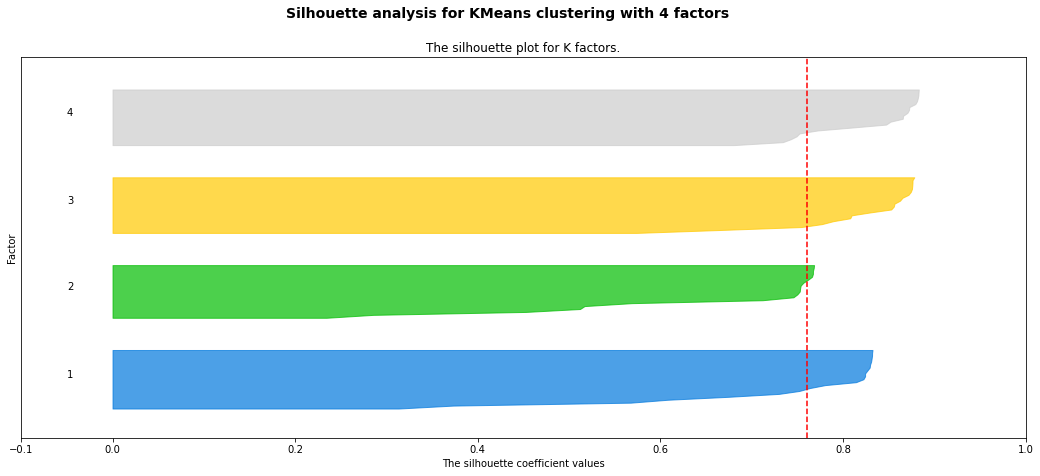

[Iter.    0]  loss:3.545119  pct:100.000000000
[Iter.   10]  loss:2.589871  pct:-26.945443041
[Iter.   20]  loss:2.590243  pct:0.014370131
[Iter.   30]  loss:2.590663  pct:0.016202834
[Iter.   40]  loss:2.590862  pct:0.007669440
[Iter.   50]  loss:2.590967  pct:0.004056600
getting worse break


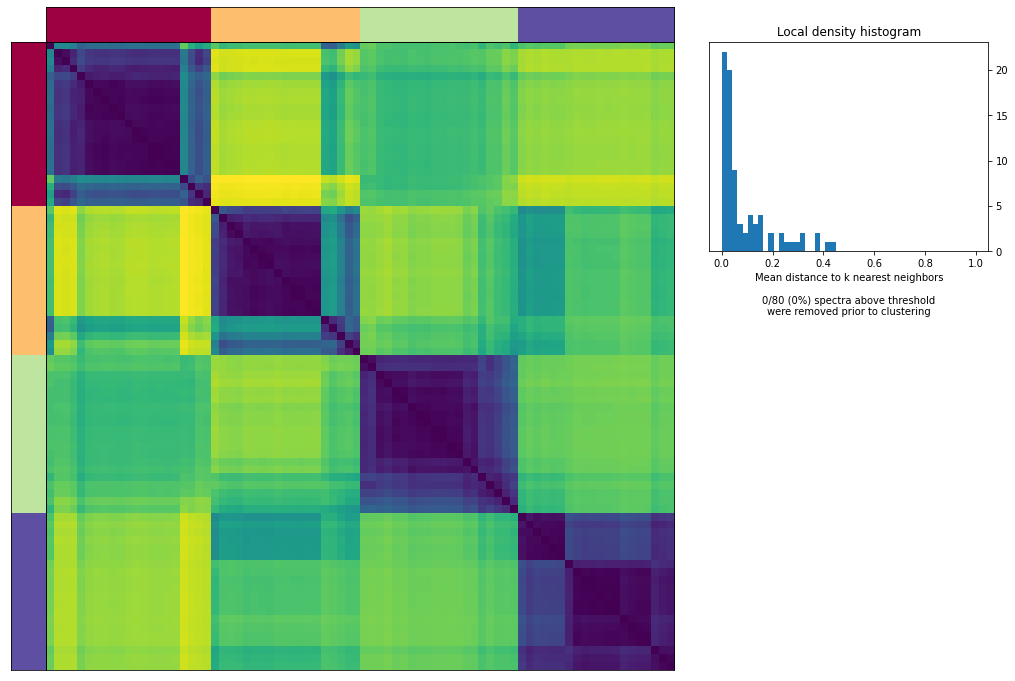

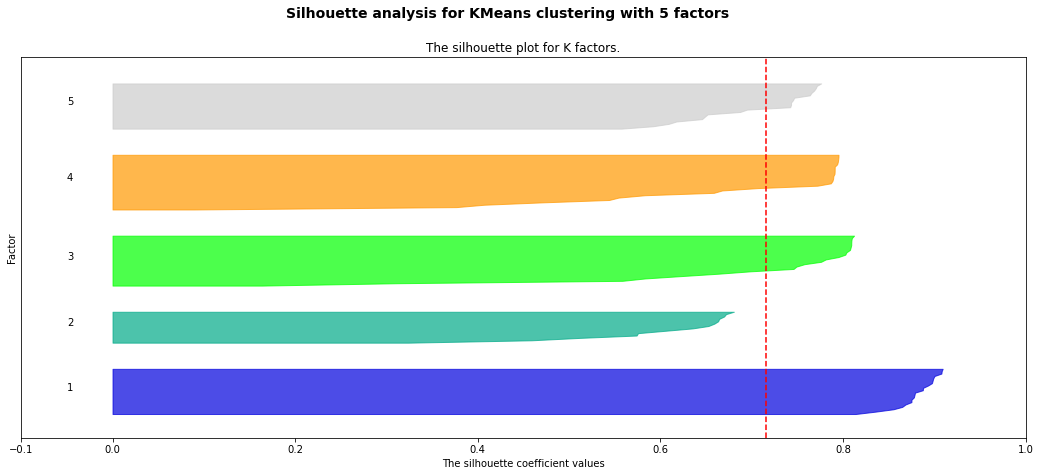

[Iter.    0]  loss:3.550019  pct:100.000000000
[Iter.   10]  loss:2.593299  pct:-26.949730390
[Iter.   20]  loss:2.592858  pct:-0.017006621
[Iter.   30]  loss:2.593040  pct:0.007029063
[Iter.   40]  loss:2.593119  pct:0.003037504
[Iter.   50]  loss:2.593158  pct:0.001518015
[Iter.   60]  loss:2.593183  pct:0.000978828
getting worse break


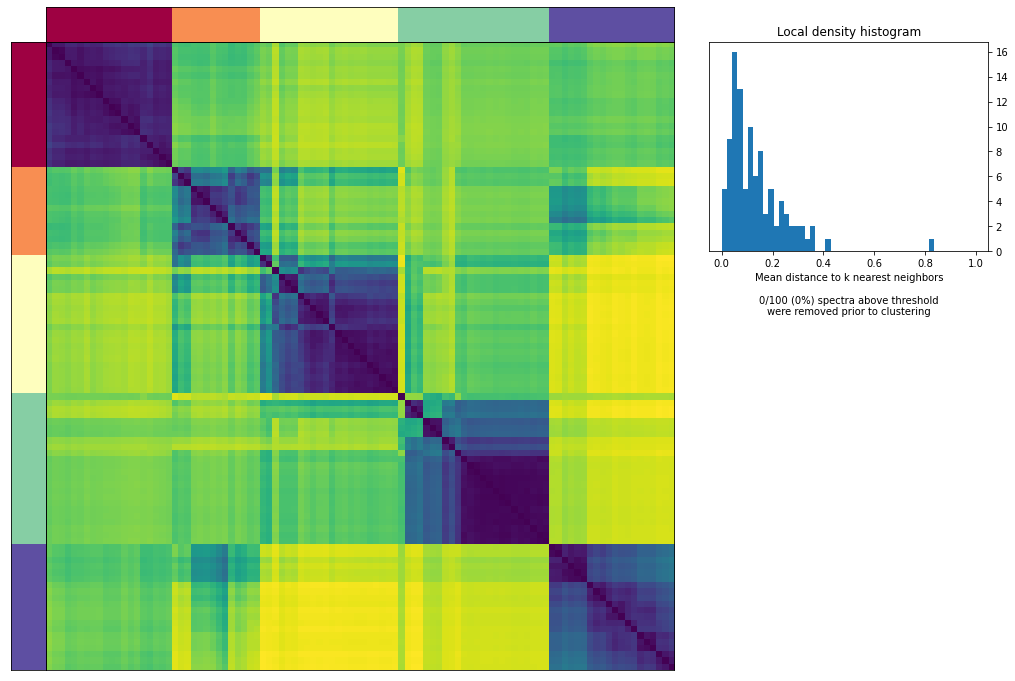

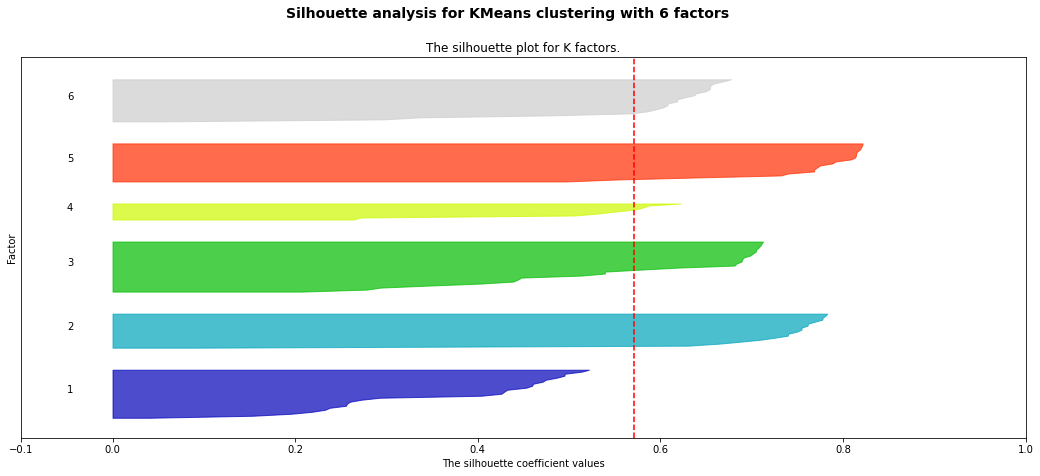

[Iter.    0]  loss:3.641857  pct:100.000000000
[Iter.   10]  loss:2.586783  pct:-28.970759590
[Iter.   20]  loss:2.586573  pct:-0.008120362
[Iter.   30]  loss:2.586823  pct:0.009674559
[Iter.   40]  loss:2.586980  pct:0.006053118
[Iter.   50]  loss:2.587081  pct:0.003894849
getting worse break


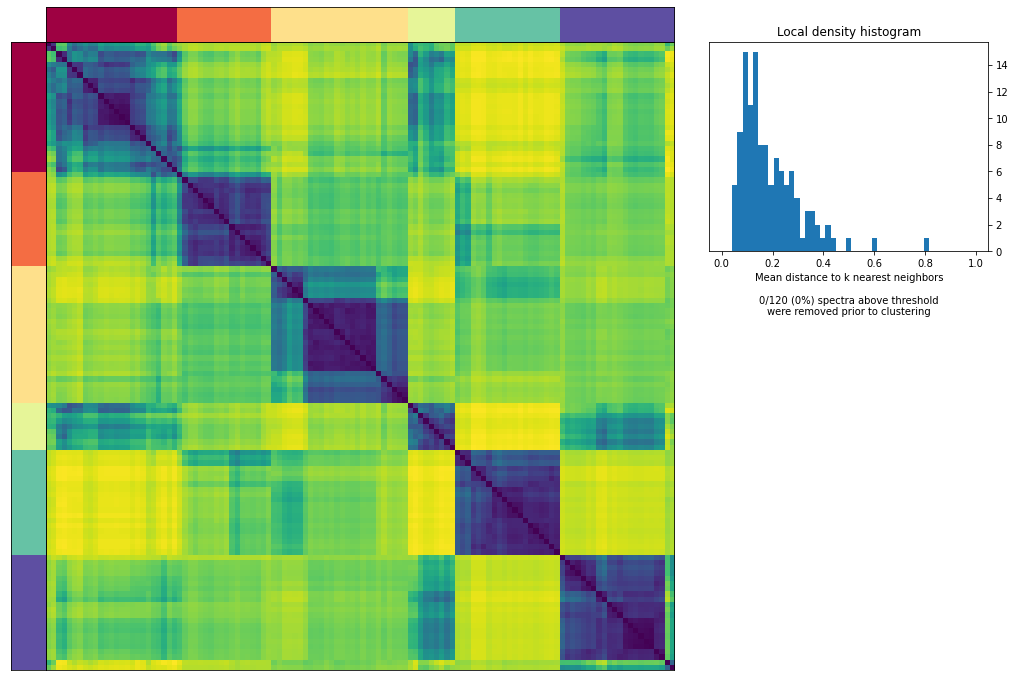

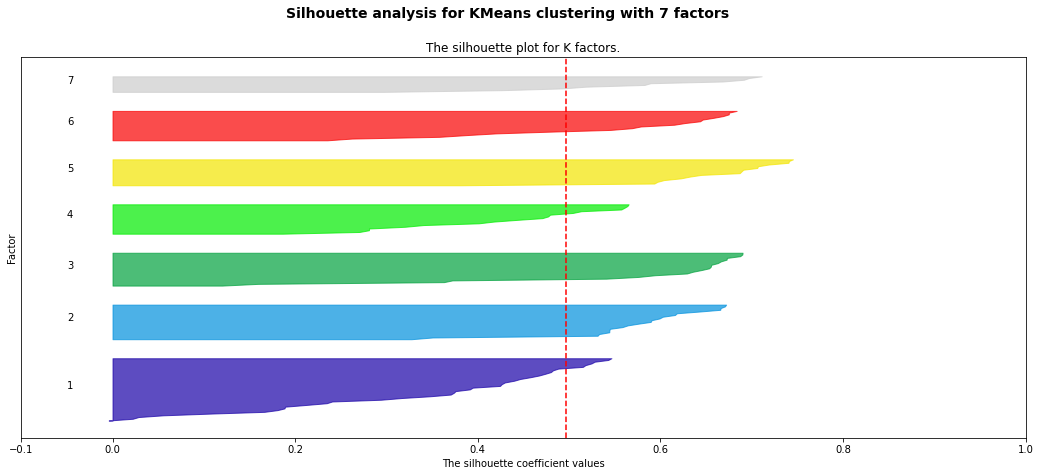

[Iter.    0]  loss:3.699704  pct:100.000000000
[Iter.   10]  loss:2.583562  pct:-30.168427512
[Iter.   20]  loss:2.583895  pct:0.012896743
[Iter.   30]  loss:2.584320  pct:0.016450646
[Iter.   40]  loss:2.584546  pct:0.008749367
[Iter.   50]  loss:2.584679  pct:0.005133574
getting worse break


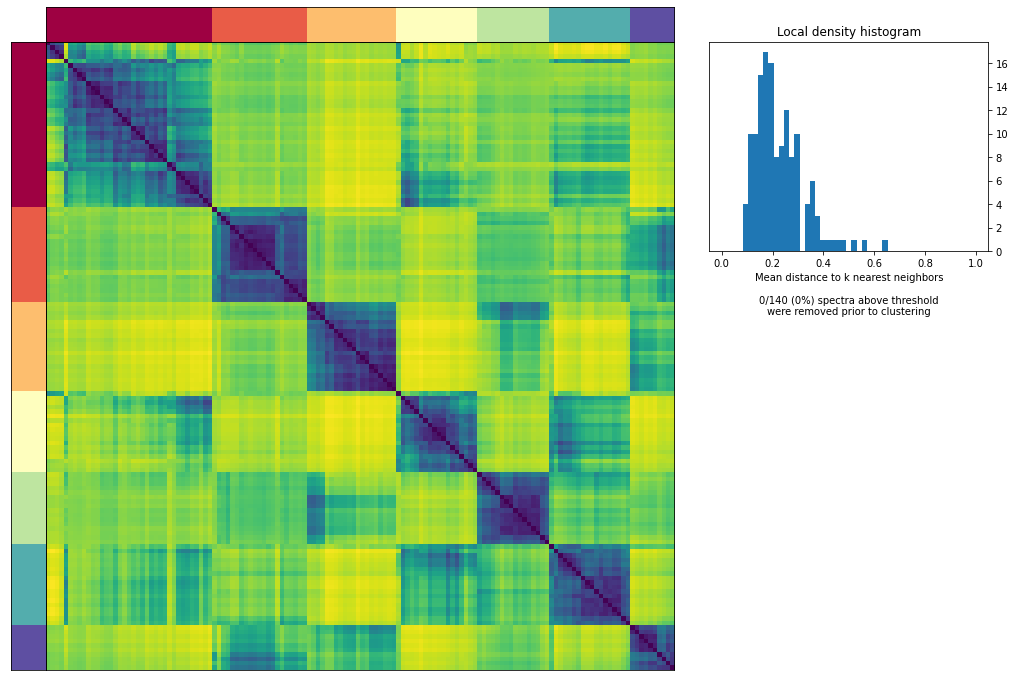

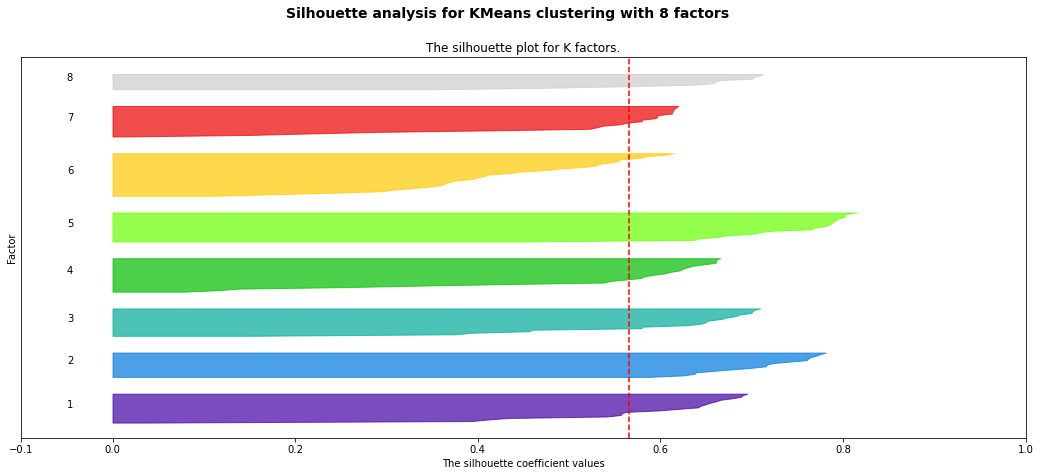

[Iter.    0]  loss:3.716365  pct:100.000000000
[Iter.   10]  loss:2.565934  pct:-30.955805983
[Iter.   20]  loss:2.566119  pct:0.007231524
[Iter.   30]  loss:2.566557  pct:0.017050741
[Iter.   40]  loss:2.566796  pct:0.009323595
[Iter.   50]  loss:2.566941  pct:0.005622569
getting worse break


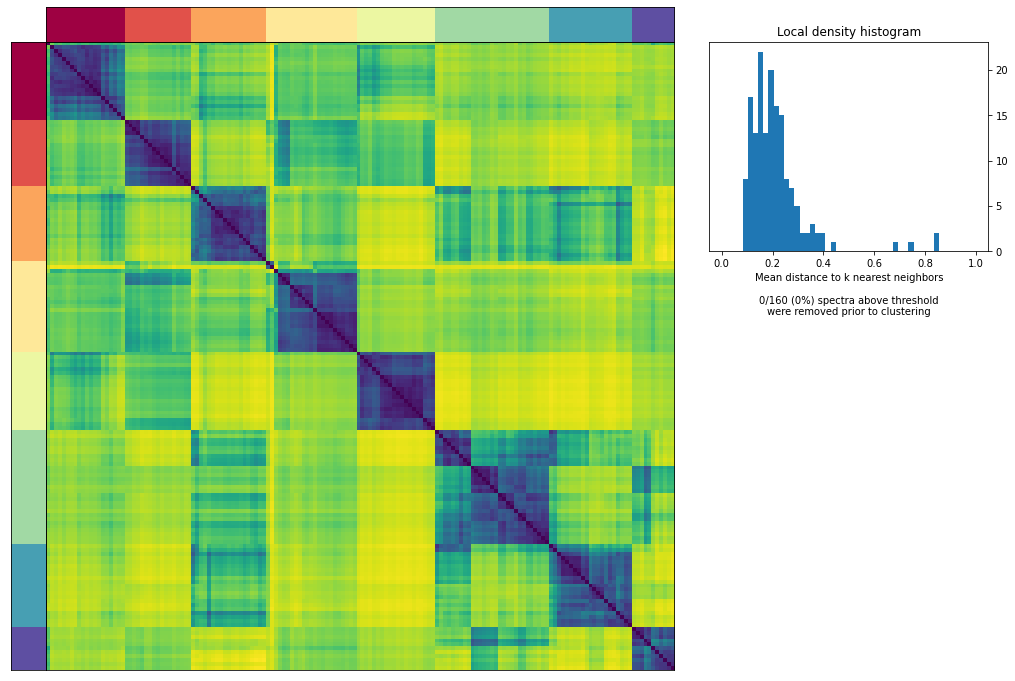

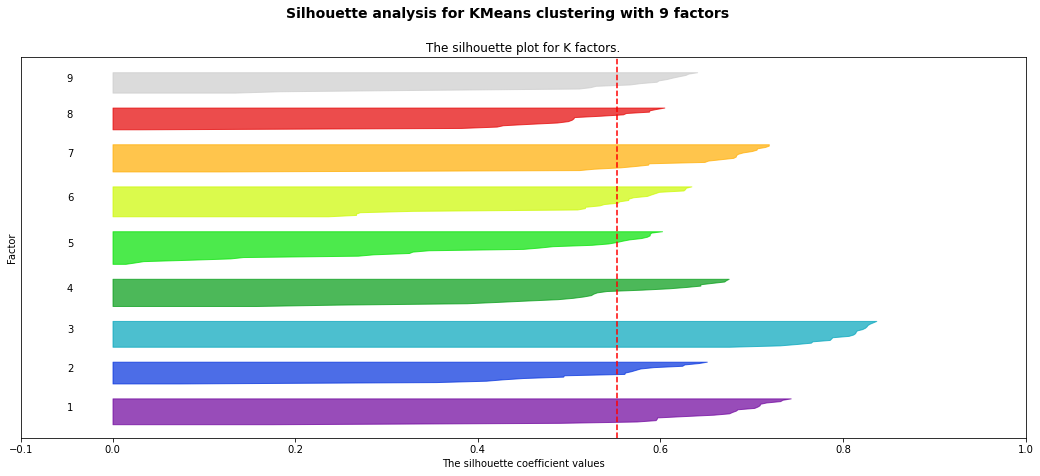

[Iter.    0]  loss:3.793956  pct:100.000000000
[Iter.   10]  loss:2.566043  pct:-32.364981197
[Iter.   20]  loss:2.566914  pct:0.033969177
[Iter.   30]  loss:2.567486  pct:0.022284825
[Iter.   40]  loss:2.567779  pct:0.011393605
[Iter.   50]  loss:2.567954  pct:0.006839581
getting worse break


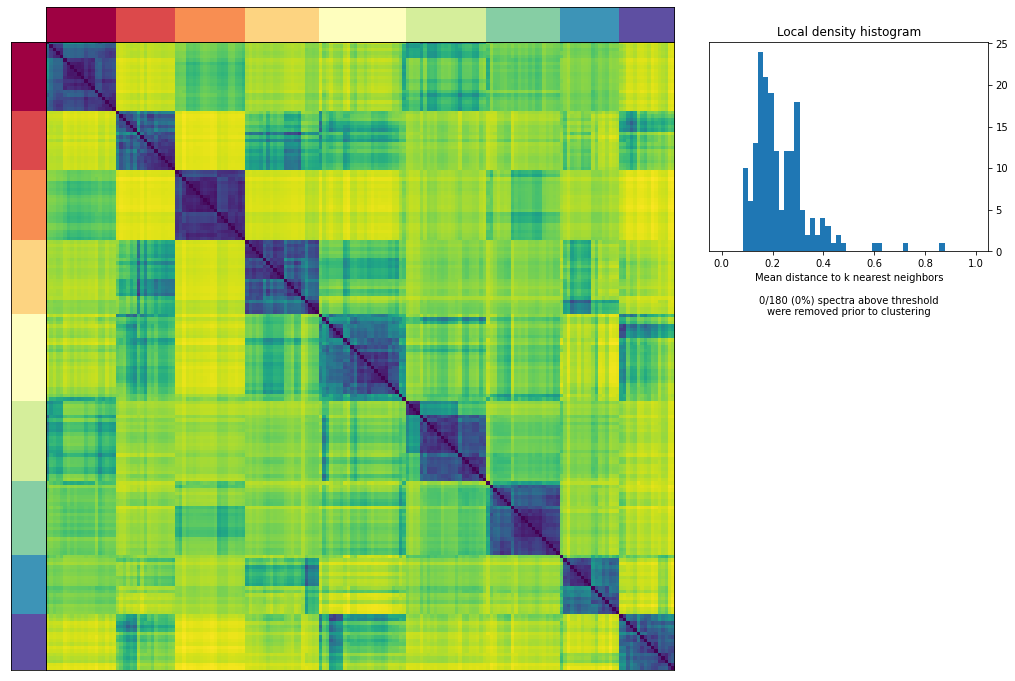

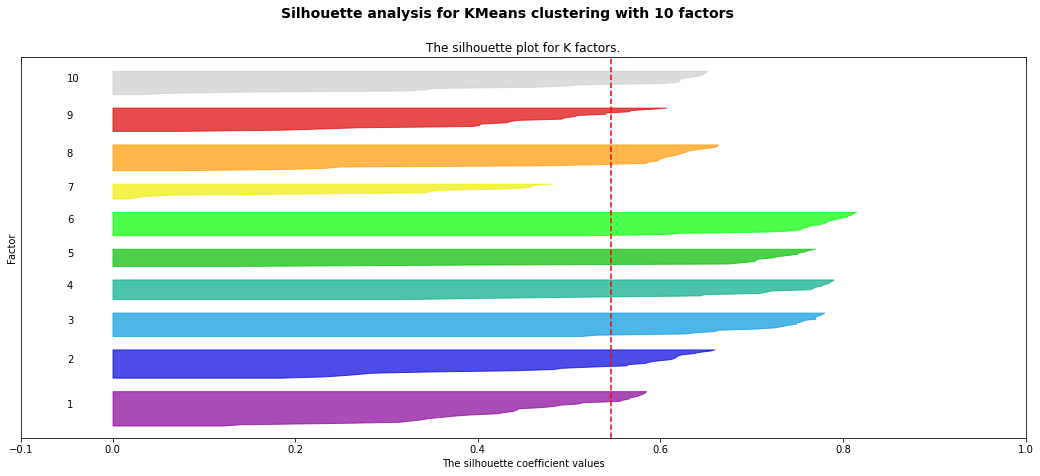

[Iter.    0]  loss:3.810979  pct:100.000000000
[Iter.   10]  loss:2.573670  pct:-32.466960248
[Iter.   20]  loss:2.573190  pct:-0.018630593
[Iter.   30]  loss:2.573470  pct:0.010877406
[Iter.   40]  loss:2.573669  pct:0.007724207
[Iter.   50]  loss:2.573802  pct:0.005153132
getting worse break


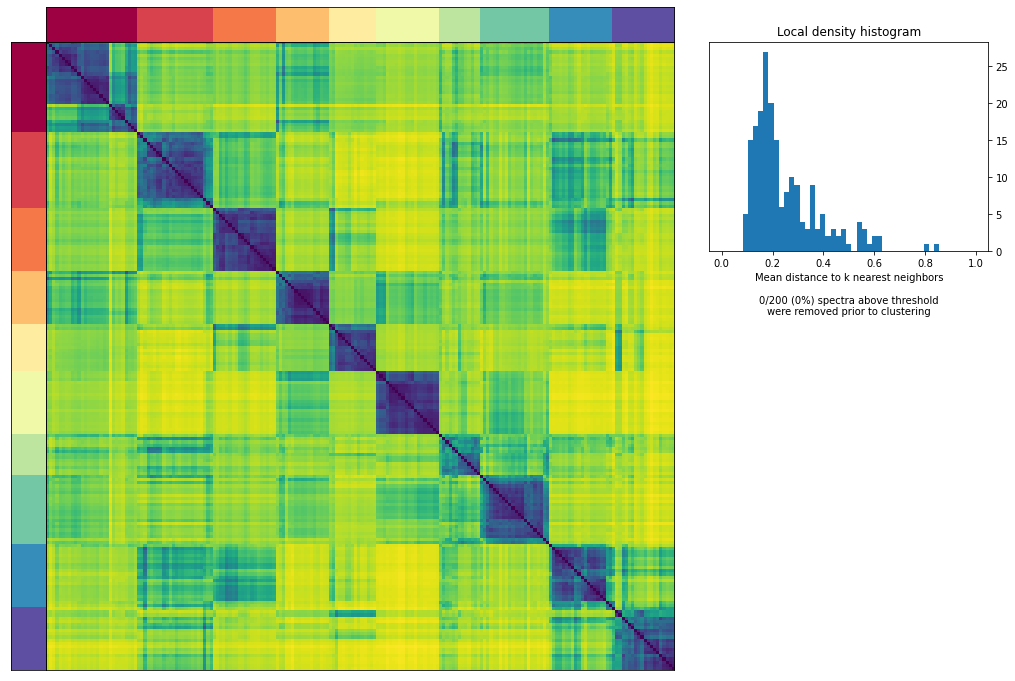

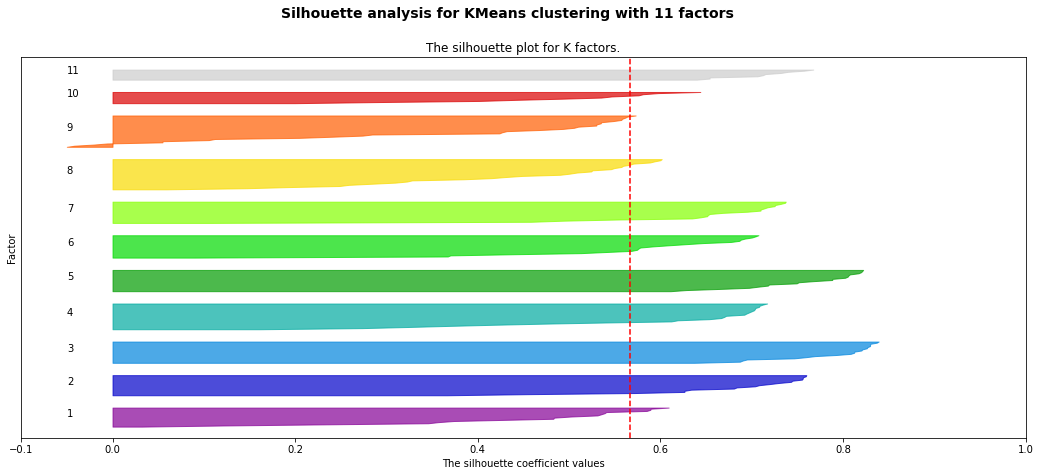

[Iter.    0]  loss:3.865380  pct:100.000000000
[Iter.   10]  loss:2.556547  pct:-33.860403201
[Iter.   20]  loss:2.556515  pct:-0.001225550
[Iter.   30]  loss:2.556971  pct:0.017809448
[Iter.   40]  loss:2.557248  pct:0.010859368
[Iter.   50]  loss:2.557426  pct:0.006961719
getting worse break


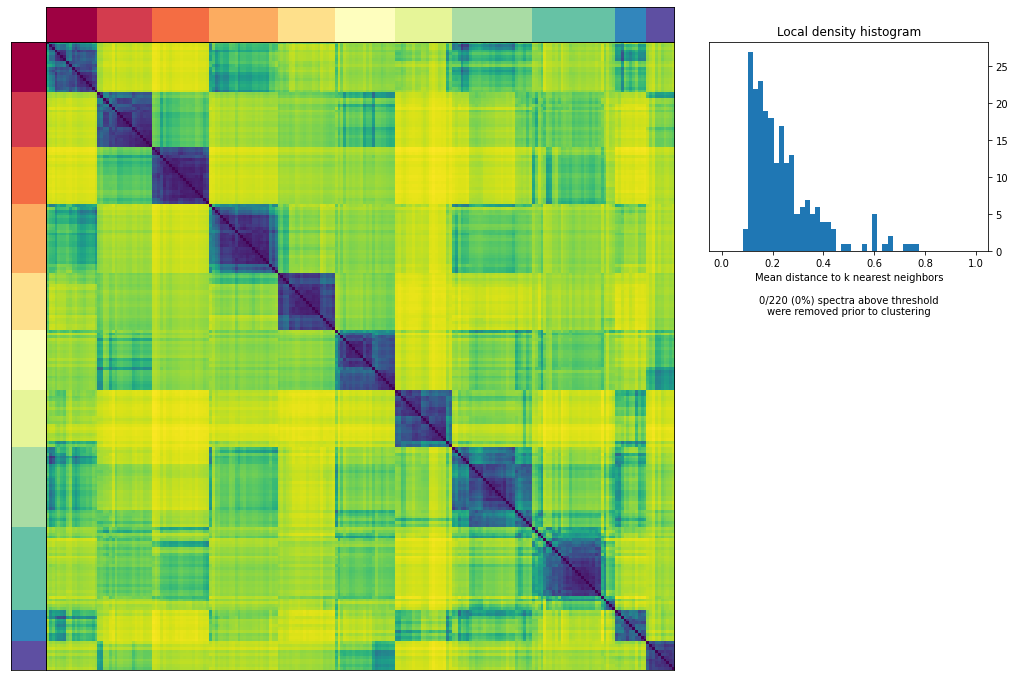

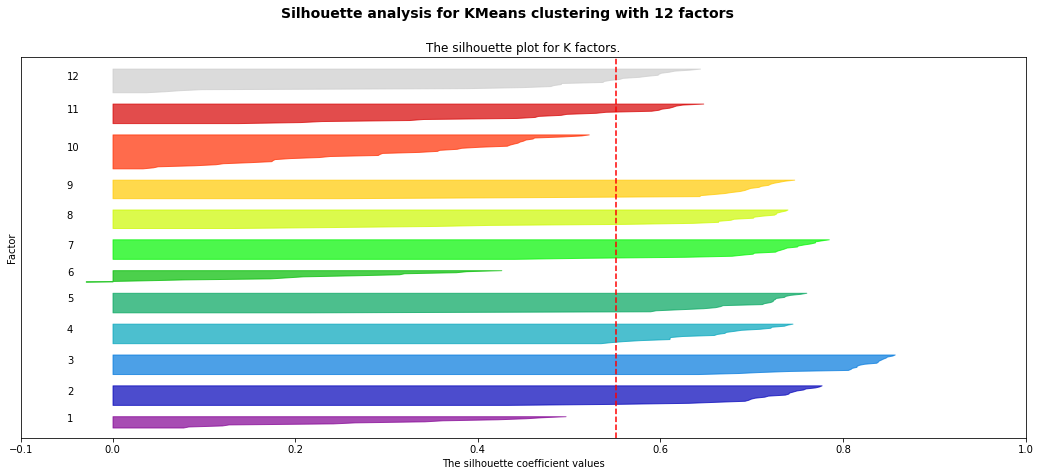

[Iter.    0]  loss:4.001410  pct:100.000000000
[Iter.   10]  loss:2.547851  pct:-36.326175134
[Iter.   20]  loss:2.547233  pct:-0.024271250
[Iter.   30]  loss:2.547452  pct:0.008597396
[Iter.   40]  loss:2.547633  pct:0.007127897
[Iter.   50]  loss:2.547768  pct:0.005276214
[Iter.   60]  loss:2.547868  pct:0.003927466
getting worse break


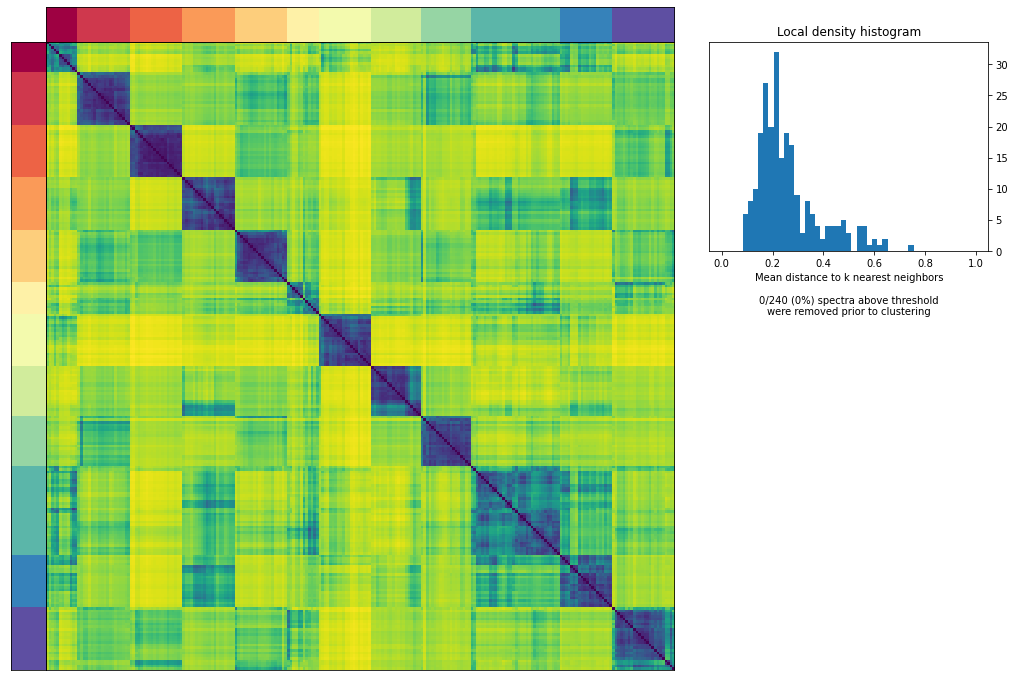

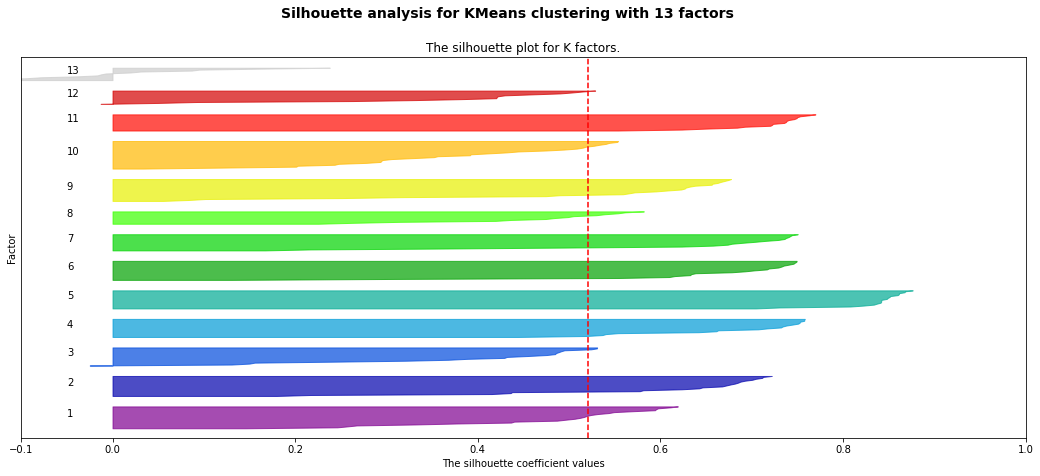

[Iter.    0]  loss:4.046134  pct:100.000000000
[Iter.   10]  loss:2.544728  pct:-37.107183720
[Iter.   20]  loss:2.544335  pct:-0.015434540
[Iter.   30]  loss:2.544537  pct:0.007944419
[Iter.   40]  loss:2.544693  pct:0.006117783
[Iter.   50]  loss:2.544810  pct:0.004584822
getting worse break


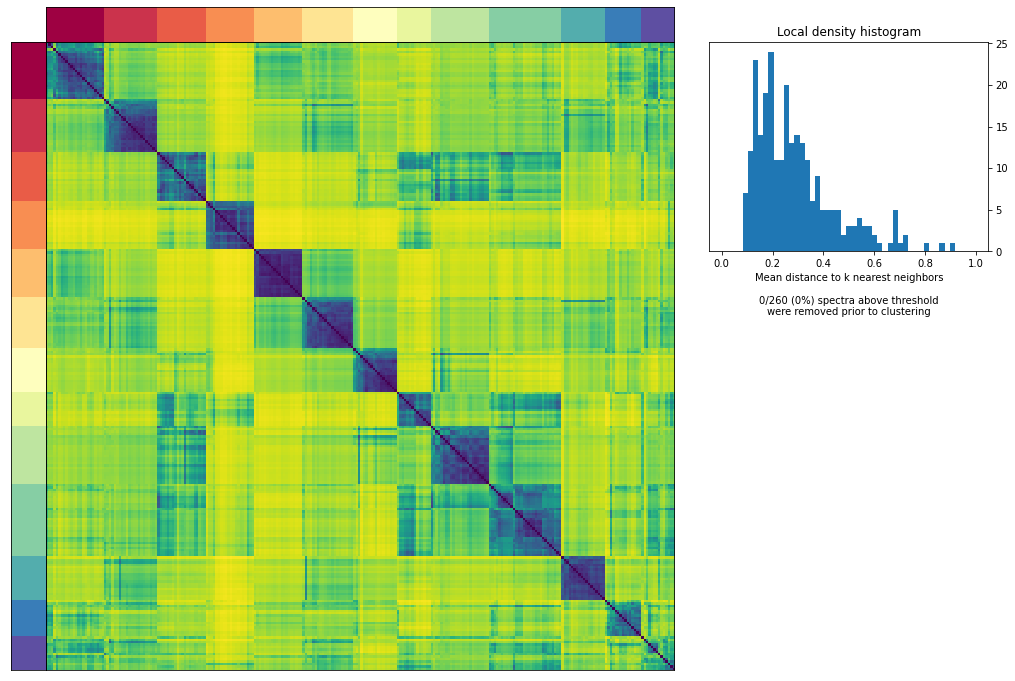

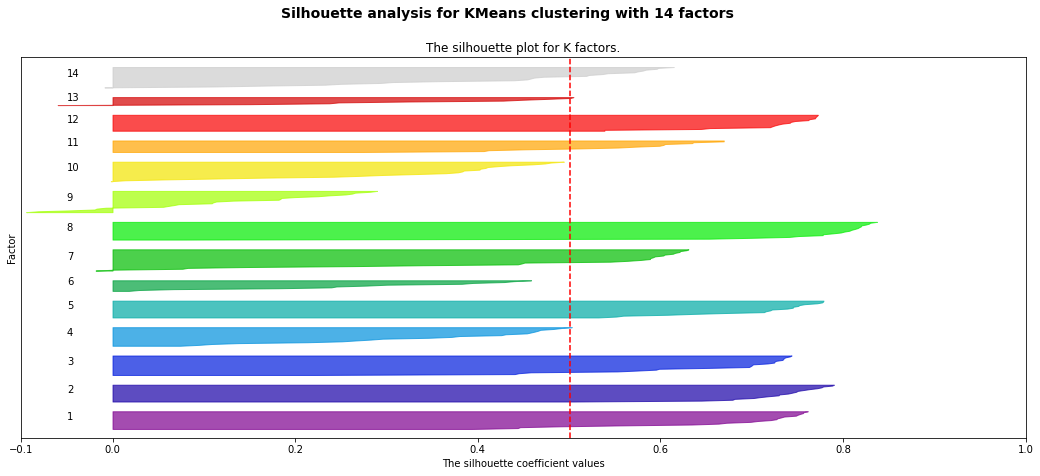

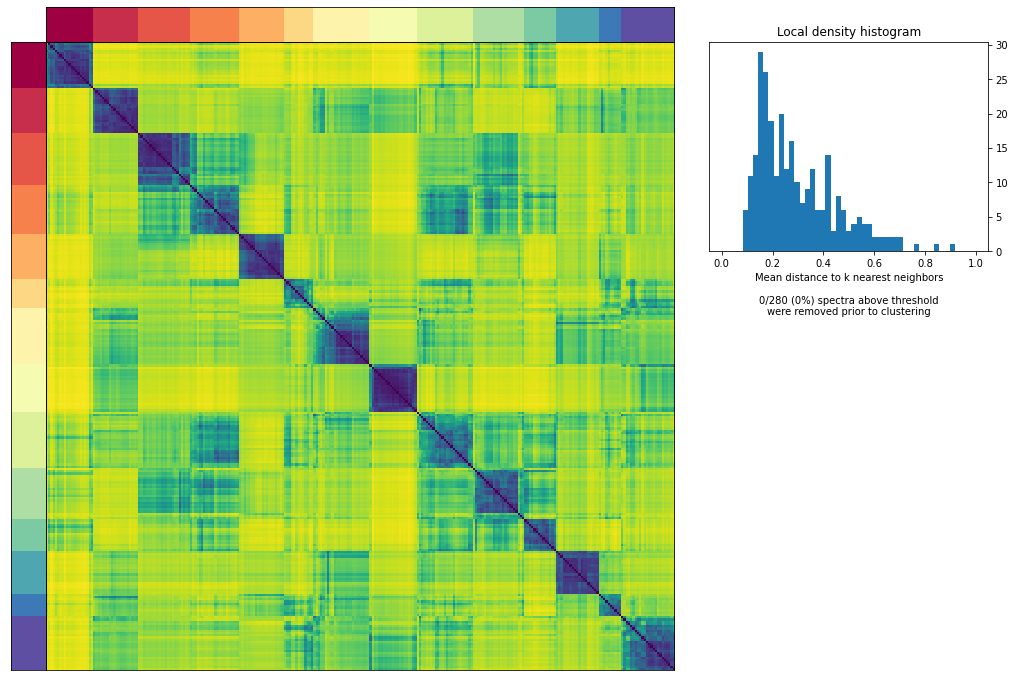

In [ ]:
# cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

n_top_genes = 20
density_threshold = 2

run_params = sccHPF.load_df_from_npz(cnmf_obj.paths['nmf_parameters'])

# retrieve the consensus for each k value and save the files
for k in ks:
    merged_spectra = sccHPF.load_df_from_npz(cnmf_obj.paths['merged_spectra']%k)
    cnmf_obj.consensus(k, density_threshold_str=str(density_threshold), show_clustering = True, close_clustergram_fig=False, train_set=train)

    # usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=i, density_threshold=density_threshold)

    scorefn = cnmf_obj.paths['gene_spectra_score__txt'] % (k, str(density_threshold).replace('.', '_'))
    # tpmfn = cnmf_obj.paths['gene_spectra_tpm__txt'] % (k, str(density_threshold).replace('.', '_'))
    usagefn = cnmf_obj.paths['consensus_usages__txt'] % (k, str(density_threshold).replace('.', '_'))
    spectra_scores = pd.read_csv(scorefn, sep='\t', index_col=0).T
    # spectra_tpm = pd.read_csv(tpmfn, sep='\t', index_col=0).T

    usage = pd.read_csv(usagefn, sep='\t', index_col=0)
    # usage = usage.div(usage.sum(axis=1), axis=0)

    try:
        usage.columns = [int(x) for x in usage.columns]
    except:
        print('Usage matrix columns include non integer values')

    top_genes = []
    for gep in spectra_scores.columns:
        top_genes.append(list(spectra_scores.sort_values(by=gep, ascending=False).index[:n_top_genes]))

    top_genes = pd.DataFrame(top_genes, index=spectra_scores.columns).T
    # usage_norm, gep_scores, gep_tpm, topgenes = usage, spectra_scores, spectra_tpm, top_genes
    gep_scores, topgenes = spectra_scores, top_genes

    if not os.path.exists("sccHPF_outputs/large_sccHPF_allcells/%d/" % k):
      os.mkdir("sccHPF_outputs/large_sccHPF_allcells/%d/" % k)
    usage.to_csv("sccHPF_outputs/large_sccHPF_allcells/%d/usage_scores.csv" % k)

    if not os.path.exists("sccHPF_outputs/large_sccHPF_allcells/%d/" % k):
      os.mkdir("sccHPF_outputs/large_sccHPF_allcells/%d/" % k)
    gep_scores.to_csv("sccHPF_outputs/large_sccHPF_allcells/%d/gep_scores.csv" % k)

    if not os.path.exists("sccHPF_outputs/large_sccHPF_allcells/%d/" % k):
      os.mkdir("sccHPF_outputs/large_sccHPF_allcells/%d/" % k)
    topgenes.to_csv("sccHPF_outputs/large_sccHPF_allcells/%d/topgenes.csv" % k)

[Iter.    0]  loss:3.542048  pct:100.000000000
[Iter.   10]  loss:2.643470  pct:-25.368899006
[Iter.   20]  loss:2.643379  pct:-0.003421123
[Iter.   30]  loss:2.643710  pct:0.012529170
[Iter.   40]  loss:2.643908  pct:0.007496026
[Iter.   50]  loss:2.644023  pct:0.004331832
getting worse break
[Iter.    0]  loss:3.545367  pct:100.000000000
[Iter.   10]  loss:2.589872  pct:-26.950523749
[Iter.   20]  loss:2.590243  pct:0.014341563
[Iter.   30]  loss:2.590663  pct:0.016203702
[Iter.   40]  loss:2.590862  pct:0.007669767
[Iter.   50]  loss:2.590967  pct:0.004055093
getting worse break
[Iter.    0]  loss:3.550137  pct:100.000000000
[Iter.   10]  loss:2.593299  pct:-26.952142737
[Iter.   20]  loss:2.592858  pct:-0.017016887
[Iter.   30]  loss:2.593040  pct:0.007019878
[Iter.   40]  loss:2.593119  pct:0.003035730
[Iter.   50]  loss:2.593158  pct:0.001520018
[Iter.   60]  loss:2.593184  pct:0.000978524
getting worse break
[Iter.    0]  loss:3.642223  pct:100.000000000
[Iter.   10]  loss:2.586

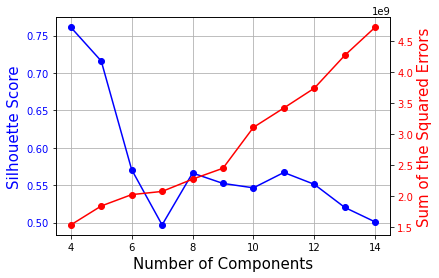

In [ ]:
# k_selection_plot

cnmf_obj.k_selection_plot(close_fig=False,
                          train_set=train)

# Preliminary Visualization

0.0214894950455936


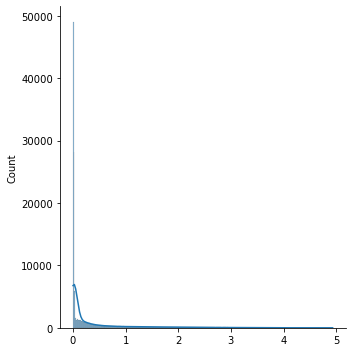

In [ ]:
import seaborn as sns

j = 4

# Visualize density distribution of the factor scores across cells
sns.displot(usage.iloc[:,j].values,
            kde=True,
            rug=False)
print(np.median(usage.iloc[:,j].values))

In [ ]:
K = 10
for i in range(1,K+1):
  large_adata.obs['Usage_%d' % i] = usage.iloc[:,i-1].values
usage

1         2         3         4         5         6         7   \
0       0.027989  0.012493  1.412660  1.550944  0.786585  0.031431  0.012125   
1       0.148720  0.005829  2.638512  0.477070  1.348521  0.014187  0.005448   
2       1.211055  0.014322  0.978002  1.404829  0.960001  0.033536  0.013587   
3       1.681208  0.004117  0.519346  0.056946  1.585738  0.011347  0.004049   
4       0.326455  0.011032  1.883930  1.202247  0.019180  0.028220  0.010855   
...          ...       ...       ...       ...       ...       ...       ...   
144350  0.012432  0.005651  1.713912  0.474861  0.861410  0.014531  0.005335   
144351  0.008620  0.003995  0.570540  0.010581  4.190037  0.009778  0.003781   
144352  0.020140  0.008617  1.397688  1.057112  0.016254  0.021012  0.008324   
144353  0.045137  0.046494  1.013488  0.144329  2.965324  0.005627  0.108772   
144354  0.183368  0.005033  1.253054  0.464522  2.793370  0.392759  0.004708   

              8         9         10        11        12        13        14  
0       0.012200  0.014630  1.103368  0.017081  0.031344  0.041849  0.008366  
1       0.005389  0.330273  0.028636  0.007362  0.014144  0.020023  0.099026  
2       0.013306  0.015736  0.296200  0.018712  0.034686  0.047555  0.009324  
3       0.004574  0.004638  1.252056  0.005565  0.010511  0.014927  0.002840  
4       0.010511  0.012919  1.486599  0.015455  0.027918  0.037030  0.007447  
...          ...       ...       ...       ...       ...       ...       ...  
144350  0.005394  0.432281  0.878042  0.700346  0.014205  0.020319  0.003767  
144351  0.003870  0.004536  0.002582  0.005130  0.010145  0.333125  0.002623  
144352  0.008646  0.688912  1.422226  0.403894  0.022106  0.028866  0.005856  
144353  0.002236  0.002441  0.556397  0.002794  0.048215  0.235300  0.001493  
144354  0.004698  0.005536  0.003159  0.007393  0.012305  0.017460  0.003249  

[144355 rows x 14 columns]

In [ ]:
large_adata.raw = large_adata

# Store raw counts in layers
large_adata.layers['counts'] = large_adata.X

# Pre-process the data
sc.pp.normalize_total(large_adata)
sc.pp.log1p(large_adata)
sc.pp.scale(large_adata)
sc.pp.highly_variable_genes(large_adata,n_top_genes=2000)
sc.pp.pca(large_adata,use_highly_variable=True)

## Construct the nearest neighbor graph for UMAP
sc.pp.neighbors(large_adata, n_neighbors=50, n_pcs=15)

## Run UMAP
sc.tl.umap(large_adata, min_dist=0.1)

/burg/home/nh2642/.local/lib/python3.9/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
/burg/home/nh2642/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:236: RuntimeWarning: invalid value encountered in true_divide
  df['dispersions_norm'] = (


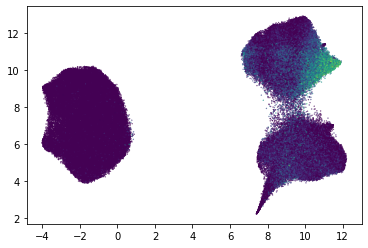

In [ ]:
plt.scatter(large_adata.obsm['X_umap'][:,0],large_adata.obsm['X_umap'][:,1],
            c=large_adata.obs['Usage_2'].values,s=0.1)
plt.show()